# Итоговое задание по курсу "Архитектор в области искусственного интеллекта"

# Тема:
#  **"Анализ временных рядов для прогнозирования цен на продукты в нефтегазовой промышленности"**

Авторы: Курамшин Р.Ю., Сираева Г.М.

Цель: Разработка и тестирование приложения для промышленности, основанного на машинном обучении.

План работы:


● Необходимо провести предварительный анализ существующих решений, доступных наборов данных, включая их сравнение.


● Необходимо разработать базовую программную реализацию модели (допускается использование существующей реализации)


● Необходимо провести эксперименты с одним или более наборами данных и представить результаты в виде отчета в формате PDF.

Установим нужные библиотеки:

In [ ]:
!pip install descartes
!pip install prettytable
!pip install transformers
!pip install skforecast
!pip install catboost
!pip install streamlit
!pip install pygwalker

In [ ]:
import os
import time

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score

from sklearn.feature_extraction.text import*
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.metrics import mean_absolute_percentage_error

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns


from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import grid_search_forecaster
from statsmodels.tsa.arima.model import ARIMA

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


from catboost import CatBoostRegressor

from descartes import PolygonPatch
import shapefile
from datetime import datetime
from dateutil.relativedelta import relativedelta

import missingno as msno
import pickle
from astropy.table import Table, Column
import gdown

import streamlit as st
from streamlit.logger import get_logger


import pygwalker as pyg
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

# Загрузим наш датасет

In [ ]:
# скачаем наш датасет
dataset_id = '1VBYFsdFtLXfYQ9OPFBD-swMlxX2-yX9L'
gdown.download(id = dataset_id)

df = pd.read_csv(f"data.csv", na_values = ['na',], header = 0, index_col = 0)
df.head(10)

Downloading...
From: https://drive.google.com/uc?id=1VBYFsdFtLXfYQ9OPFBD-swMlxX2-yX9L
To: /content/data.csv
100%|██████████| 27.2M/27.2M [00:00<00:00, 95.9MB/s]


,param1,param2,date,time
0,42.6,6,2021-01-01 00:00:00+00,00:04:21
1,46.0,7,2021-01-01 00:00:00+00,00:16:26
2,42.6,6,2021-01-01 00:00:00+00,00:24:35
3,43.3,5,2021-01-01 00:00:00+00,00:32:55
4,46.0,7,2021-01-01 00:00:00+00,00:39:38
5,46.0,7,2021-01-01 00:00:00+00,00:40:52
6,43.3,5,2021-01-01 00:00:00+00,00:43:16
7,43.3,5,2021-01-01 00:00:00+00,00:48:51
8,43.3,5,2021-01-01 00:00:00+00,00:55:40
9,46.0,7,2021-01-01 00:00:00+00,00:56:24


Собранный датасет представляет собой данные по категориям продуктов (param2) и их стоимость (param1) за 2021-2023гг. по АЗС города Альметьевск, Республика Татарстан

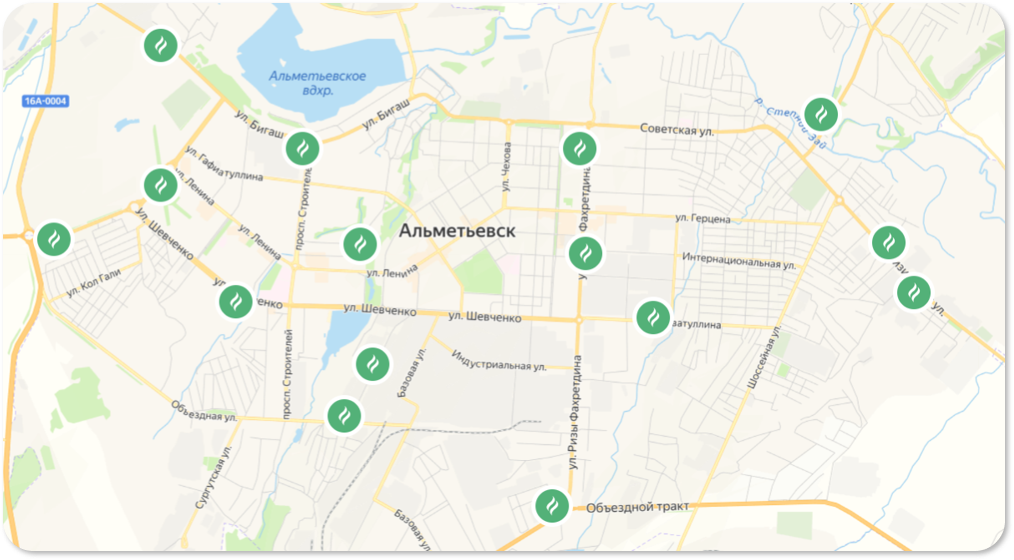

# Проведем EDA (разведочный анализ данных) нашего датасета

In [ ]:
# посмотрим из скольки столбцов и срок состоит наш датасет
df.shape

(595436, 4)

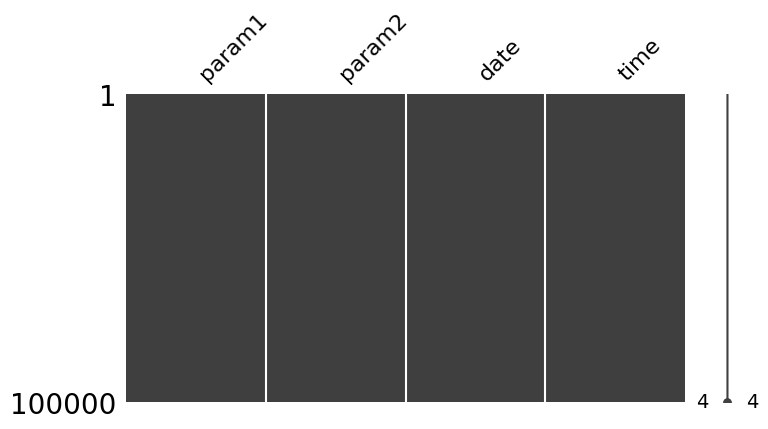

In [ ]:
# проверим наш датасет на пропущенные значения
%matplotlib inline
msno.matrix(df.sample(100000), figsize = (8, 4));

In [ ]:
# во всем датасете нет пропущенных значений
print('Количество пропущенных значений в датасете: ', df.isnull().T.any().T.sum())

Количество пропущенных значений в датасете:  0


In [ ]:
# выведем информацию по признакам и их данным
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 595436 entries, 0 to 161737
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   param1  595436 non-null  float64
 1   param2  595436 non-null  int64  
 2   date    595436 non-null  object 
 3   time    595436 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 22.7+ MB


По результатам анализа, в датасете отсутствуют пропущенные значения или NaN

Рассмотрим наши числовые признаки

In [ ]:
# выведем статистическую информацию по числовым признакам
df.describe()

,param1,param2
count,595436.000000,595436.000000
mean,47.794218,5.680604
std,3.200121,1.395304
min,42.600000,1.000000
25%,45.850000,5.000000
50%,46.900000,6.000000
75%,49.300000,7.000000
max,67.800000,8.000000


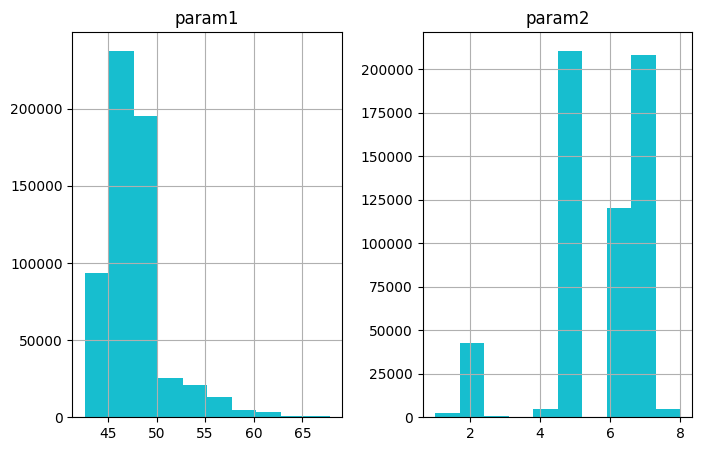

In [ ]:
# посмотрим распределение наших признаков
gist=df.hist(figsize=(8,5), color = '#17becf')
plt.show()

In [ ]:
# по признаку param2 выведем уникальные значения
list_param2 = df.param2.unique()
list_param2.sort()
list_param2
n_par2 = df.param2.nunique()
n_par2

8

In [ ]:
# посмотрим частоту распределения уникальных значений по признаку param2
df.param2.value_counts(dropna = False, normalize=True, ascending = False)

5    0.353942
7    0.349525
6    0.201719
2    0.071999
8    0.008431
4    0.008233
1    0.004464
3    0.001686
Name: param2, dtype: float64

Визуализируем наше распределение по признаку param2

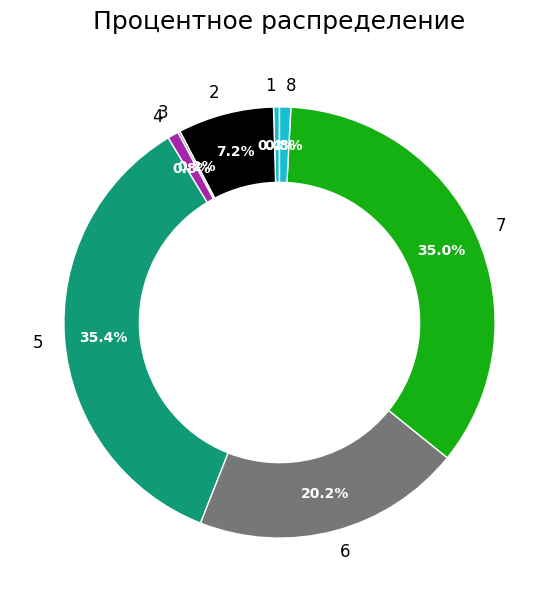

In [ ]:
# зададим общие параметры для графика
width = 14

# создадим копию нашего датасета
goods_df = df

# создадим список уникальных значений param2
goods = goods_df.groupby('param2')['param2'].count().reset_index(name='count')
goods_list = goods['param2'].unique()


# определим используемые цвета
custom_palette = ['#17becf', 'black', 'grey', '#A526AB', '#109A76', '#777777', "#15B012", "#17becf"]


# создадим кольцевую диаграмму распределения по типам топлива
sizes = goods['count']
labels = goods['param2']
colors = custom_palette[:len(sizes)]

fig, ax = plt.subplots(figsize=(width,7))


# определим сердце кольцевой диаграммы
wedgeprops = {"edgecolor": "w", 'linewidth': 1, 'width': 0.35}

# определим настройки нашей диаграммы
_, lab, pct = ax.pie(sizes, labels=labels, colors=colors, startangle=90,
                    wedgeprops=wedgeprops, autopct='%1.1f%%', pctdistance=0.82)

# установим цвет
plt.setp(lab, color='black', fontsize= 12)
plt.setp(pct, color='white', fontsize= 10, fontweight= 'bold')

# определим название диаграммы
plt.title("Процентное распределение", fontsize=18,  y=1.03)


# выводим диаграмму
plt.show()

In [ ]:
print("В признаке param2 у нас всего ", max(goods_list), " категорий")

В признаке param2 у нас всего  8  категорий


Рассмотрим временные признаки

In [ ]:
# признак date приведем к формату даты
df.date = df.date.astype('datetime64[ns]')
df.head(10)

,param1,param2,date,time
0,42.6,6,2021-01-01,00:04:21
1,46.0,7,2021-01-01,00:16:26
2,42.6,6,2021-01-01,00:24:35
3,43.3,5,2021-01-01,00:32:55
4,46.0,7,2021-01-01,00:39:38
5,46.0,7,2021-01-01,00:40:52
6,43.3,5,2021-01-01,00:43:16
7,43.3,5,2021-01-01,00:48:51
8,43.3,5,2021-01-01,00:55:40
9,46.0,7,2021-01-01,00:56:24


In [ ]:
# посмотрим информацию по датасету, изменился ли тип по признаку date
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 595436 entries, 0 to 161737
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   param1  595436 non-null  float64       
 1   param2  595436 non-null  int64         
 2   date    595436 non-null  datetime64[ns]
 3   time    595436 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 22.7+ MB


In [ ]:
# посмотри количество представленных в датасете годов и месяцев
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
print('Года, представленные в анализе: ', df.year.unique())
print('Месяцы, представленные в анализе: ', df.month.unique())

Года, представленные в анализе:  [2021 2022 2023]
Месяцы, представленные в анализе:  [ 1  2  3  4  5  6  7  8  9 10 11 12]


In [ ]:
# выведем первые 10 строк датафрейма
df.head(10)

,param1,param2,date,time,year,month
0,42.6,6,2021-01-01,00:04:21,2021,1
1,46.0,7,2021-01-01,00:16:26,2021,1
2,42.6,6,2021-01-01,00:24:35,2021,1
3,43.3,5,2021-01-01,00:32:55,2021,1
4,46.0,7,2021-01-01,00:39:38,2021,1
5,46.0,7,2021-01-01,00:40:52,2021,1
6,43.3,5,2021-01-01,00:43:16,2021,1
7,43.3,5,2021-01-01,00:48:51,2021,1
8,43.3,5,2021-01-01,00:55:40,2021,1
9,46.0,7,2021-01-01,00:56:24,2021,1


In [ ]:
# создадим копию датафрейма и переназначим индексы на даты
df2 = pd.DataFrame(df.groupby(['date', 'param2']).param1.mean().reset_index())
df2 = df2.set_index('date')
df2

,param2,param1
date,,
2021-01-01,1,46.95
2021-01-01,2,47.70
2021-01-01,4,53.40
2021-01-01,5,43.30
2021-01-01,6,42.60
...,...,...
2023-10-28,3,67.80
2023-10-28,5,49.80
2023-10-28,6,49.10


p-значение ниже порогового значения (0.05), значит мы можем считать ряд стационарным

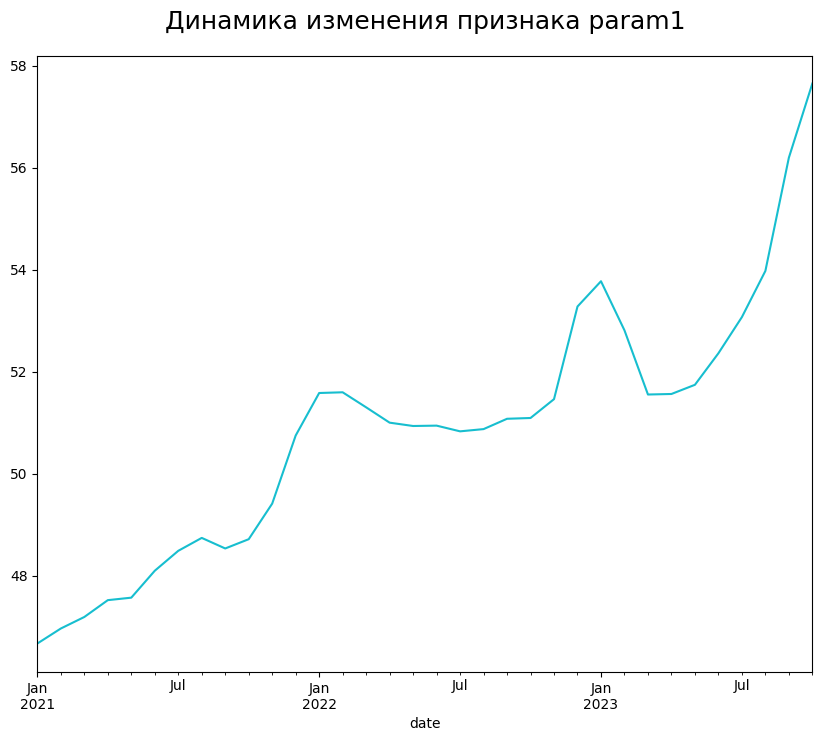

In [ ]:
# зададим размеры графика
fig, ax = plt.subplots(figsize=(10,8))

# определим название диаграммы
plt.title("Динамика изменения признака param1", fontsize=18,  y=1.03)

# посмотрим динамику изменения признака param1 по месяцам представленных лет
df2['param1'].resample('M').mean().plot(color = '#17becf');

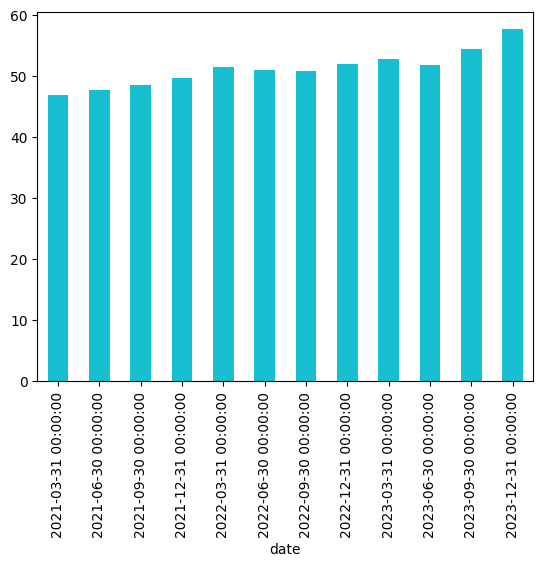

In [ ]:
# посмотрим динамику изменения признака param1 по кварталам представленных лет
df2['param1'].resample('Q').mean().plot(kind = 'bar', color = '#17becf');

In [408]:
# создадим копию датафрейма и переназначим индексы на даты
df5 = pd.DataFrame(df.groupby(['date']).param1.mean().reset_index())
df5 = df5.set_index('date')
df5

,param1
date,
2021-01-01,44.438155
2021-01-02,44.552558
2021-01-03,44.399842
2021-01-04,44.331014
2021-01-05,44.574889
...,...
2023-10-24,52.260948
2023-10-25,52.168829
2023-10-26,51.965017


In [410]:
# Проверка стационарности ряда
from statsmodels.tsa.stattools import adfuller

result = adfuller(df5['param1'])
print('ADF статистика:', result[0])
print('p-значение:', result[1])
print('Критические значения:')
for key, value in result[4].items():
    print(f'  {key}: {value}')

ADF статистика: 0.3378476247423892
p-значение: 0.9790158150866987
Критические значения:
  1%: -3.4367583914990565
  5%: -2.8643694008477407
  10%: -2.568276496427715


In [411]:
# Создадим и обучим модель ARIMA
model = ARIMA(df5['param1'], order=(1, 1, 1))
model_fit = model.fit()

# Вывод статистики модели
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                 param1   No. Observations:                 1030
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 476.296
Date:                Sun, 19 Nov 2023   AIC                           -946.592
Time:                        16:26:40   BIC                           -931.782
Sample:                             0   HQIC                          -940.971
                               - 1030                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0559      0.044     -1.259      0.208      -0.143       0.031
ma.L1         -0.5493      0.032    -16.938      0.000      -0.613      -0.486
sigma2         0.0232      0.001     28.119      0.0

In [413]:
# прогноз на основе обученной модели
forecast = model_fit.forecast(steps=12)

# рассчитываем MAE, MSE, r^2
mape = mean_absolute_percentage_error(df5['param1'][-12:], forecast)
mae = mean_absolute_error(df5['param1'][-12:], forecast)
mse = mean_squared_error(df5['param1'][-12:], forecast)
r2 = r2_score(df5['param1'][-12:], forecast)

print(f'MAPE: {mape}')
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'R^2: {r2}')

MAPE: 0.002122224367147585
MAE: 0.11058441348232446
MSE: 0.01854636025154704
R^2: -0.06673892066011167


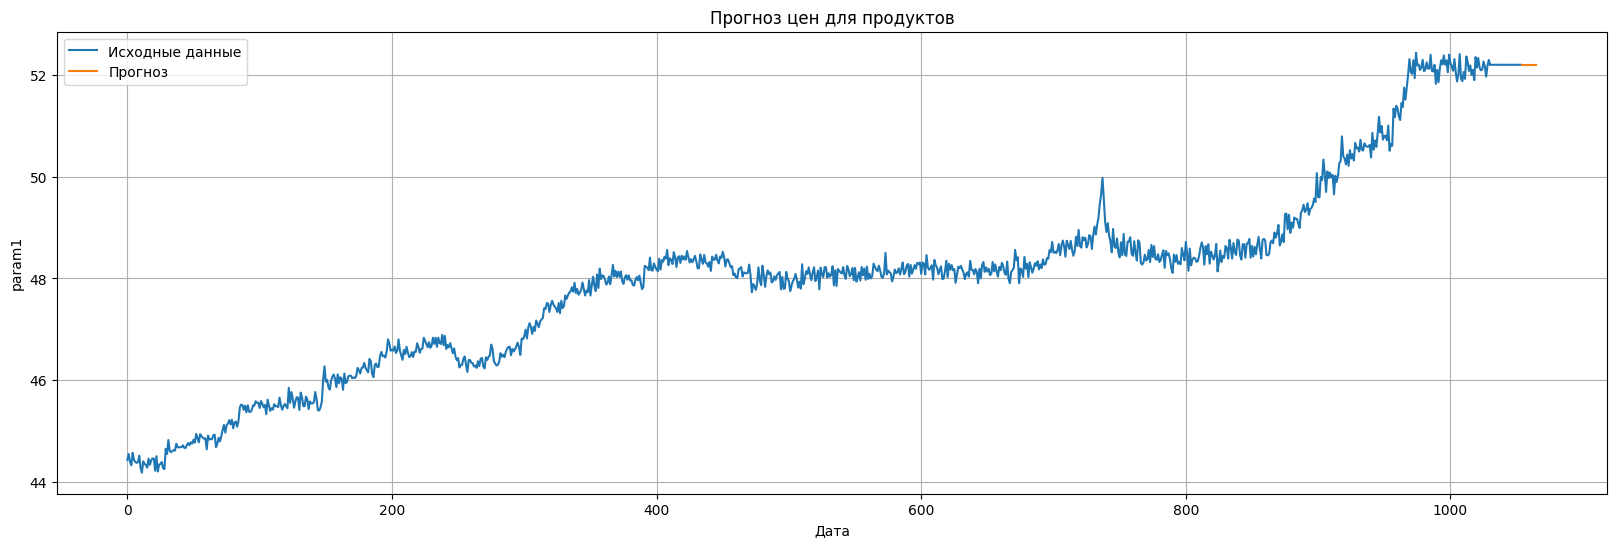

In [414]:
# Прогноз на будущее (следующие 36 месяцев)
forecast_future = model_fit.forecast(steps=36)

# создаем новый DataFrame для будущих значений
future_dates = pd.date_range(start='2023-11-01', periods=36, freq='M')
forecast_d = pd.DataFrame({'Дата': future_dates, 'param1': forecast_future})

# присоединяем прогноз к исходному DataFrame
df5 = df5.append(forecast_d, ignore_index=True)

# визуализализируем исходные данные и прогнозы
plt.figure(figsize=(20, 6))
plt.plot(df5.index[:-12], df5['param1'][:-12], label='Исходные данные')
plt.plot(df5.index[-12:], df5['param1'][-12:], label='Прогноз')
plt.title('Прогноз цен для продуктов')
plt.xlabel('Дата')
plt.ylabel('param1')
plt.legend()
plt.grid(True)
plt.show()

По графику видно, что прогнозные значения по param1 не имеют направление тренда.

Посмотрим отдельно по категориям.

In [ ]:
# создадим свои датафреймы для каждого уникального значения в param2: n_par2
print('Количество уникальных значений в param2: ', n_par2)


df_1 = df2.loc[df2["param2"] == 1]
print('Количество строк и столбцов для df_1: ', df_1.shape)

df_2 = df2.loc[df2["param2"] == 2]
print('Количество строк и столбцов для df_2: ', df_2.shape)

df_3 = df2.loc[df2["param2"] == 3]
print('Количество строк и столбцов для df_3: ', df_3.shape)

df_4 = df2.loc[df2["param2"] == 4]
print('Количество строк и столбцов для df_4: ', df_4.shape)

df_5 = df2.loc[df2["param2"] == 5]
print('Количество строк и столбцов для df_5: ', df_5.shape)

df_6 = df2.loc[df2["param2"] == 6]
print('Количество строк и столбцов для df_6: ', df_6.shape)

df_7 = df2.loc[df2["param2"] == 7]
print('Количество строк и столбцов для df_7: ', df_7.shape)

df_8 = df2.loc[df2["param2"] == 8]
print('Количество строк и столбцов для df_8: ', df_8.shape)

Количество уникальных значений в param2:  8
Количество строк и столбцов для df_1:  (463, 2)
Количество строк и столбцов для df_2:  (1030, 2)
Количество строк и столбцов для df_3:  (208, 2)
Количество строк и столбцов для df_4:  (550, 2)
Количество строк и столбцов для df_5:  (1030, 2)
Количество строк и столбцов для df_6:  (1030, 2)
Количество строк и столбцов для df_7:  (1030, 2)
Количество строк и столбцов для df_8:  (480, 2)


In [ ]:
# создадим функцию визуализации
def vis(x):
    # зададим размеры графика
    fig, ax = plt.subplots(figsize=(7,3))

    # определим название диаграммы
    plt.title("Динамика изменения признака param1", fontsize=18,  y=1.03)

    # посмотрим динамику изменения признака param1 по месяцам представленных лет
    x['param1'].resample('M').mean().plot(color = '#17becf');

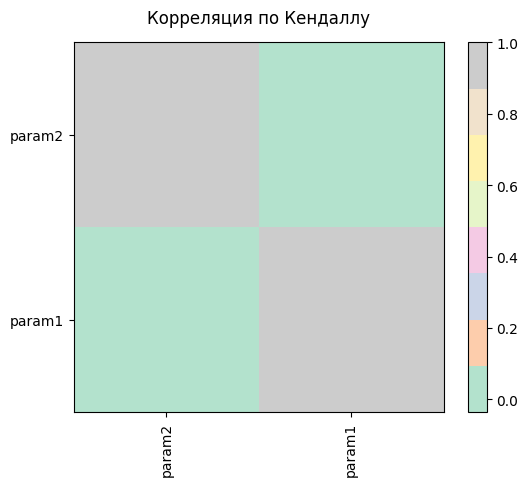

In [ ]:
# рассмотрим корреляцию между признаками param1 и param2
plt.imshow(df2.corr(method='kendall'), cmap="Pastel2");
plt.yticks(range(df2.shape[1]), df2.columns);
plt.xticks(range(df2.shape[1]), df2.columns, rotation='vertical');
plt.title(label='Корреляция по Кендаллу', y=1.03)
plt.colorbar();

Корреляция между признаками param1 и param2 минимальна

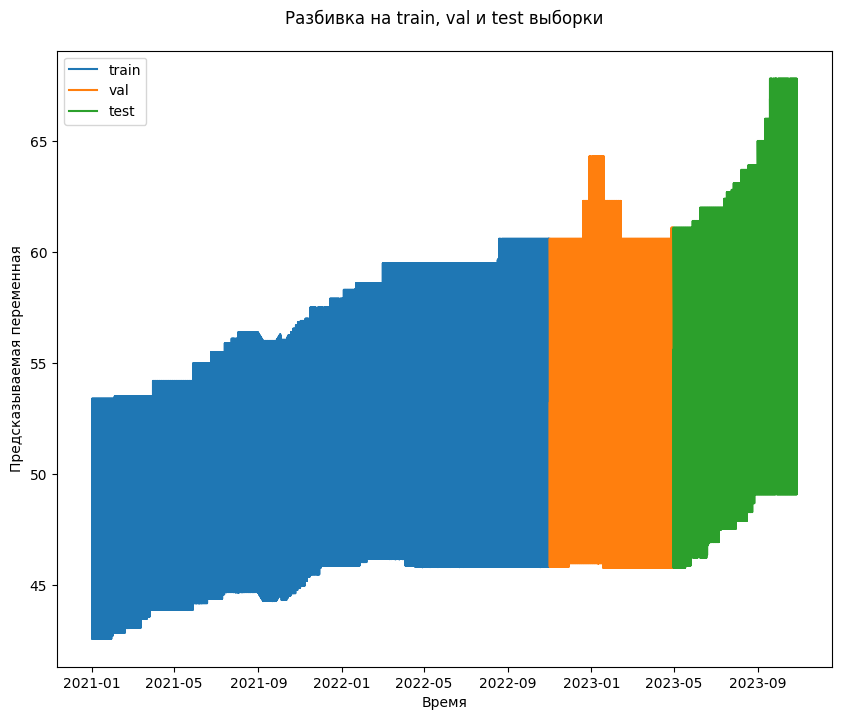

In [ ]:
# определим границы наших выборок по дате
val_start = pd.to_datetime('2022-11-01')
test_start = pd.to_datetime('2023-05-01')

# разделим наши данные на train, val и test выборки
train = df2[df2.index < val_start]
val = df2[(df2.index >= val_start) & (df2.index < test_start)]
test = df2[(df2.index >= test_start)]

# отрисуем данные для диапазона значений по всем категориям продуктов
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.plot(train.param1, label='train')
ax.plot(val.param1, label='val')
ax.plot(test.param1, label='test')
ax.set_xlabel('Время')
ax.set_ylabel('Предсказываемая переменная')
plt.title(label='Разбивка на train, val и test выборки', y=1.03)
plt.legend()
plt.show()

# 1 категория продукта

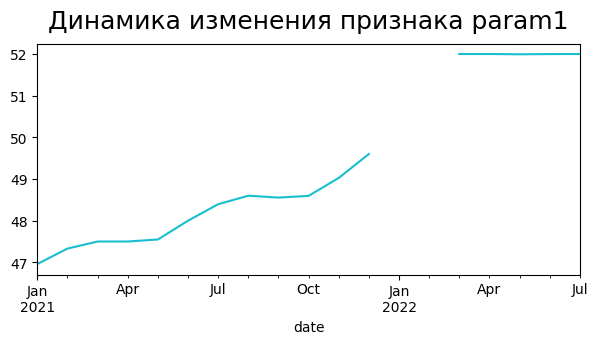

In [ ]:
# посмотрим динамику изменения признака param1 по месяцам представленных лет для param2 = 1
vis(df_1)

Как видно из графика, данные отсутствуют за зимний период 2021-2022 года и с лета 2022 года данные не поступали. Возможно это связано с сезонным фактором или изменением товарной номенклатуры в пользу другой категории товара.

In [ ]:
df_1.isnull().T.any().T.sum()

0

Обучающая выборка для 1 категории имеет размер:      179
Валидационная выборка для 1 категории имеет размер:  162
Тестовая выборка для 1 категории имеет размер:       122



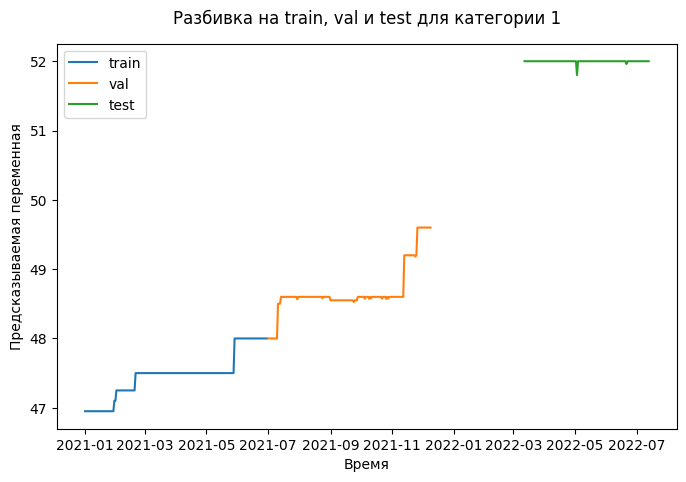

In [ ]:
# определим границы наших выборок по дате
val_start_1 = pd.to_datetime('2021-07-01')
test_start_1 = pd.to_datetime('2022-01-01')

# разделим наши данные на train, val и test выборки
train_1 = df_1[df_1.index < val_start_1]
train_1 = train_1.loc[:,'param1']

val_1 = df_1[(df_1.index >= val_start_1) & (df_1.index < test_start_1)]
val_1 = val_1.loc[:,'param1']

test_1 = df_1[(df_1.index >= test_start_1)]
test_1 = test_1.loc[:,'param1']



print('Обучающая выборка для 1 категории имеет размер:     ', len(train_1))
print('Валидационная выборка для 1 категории имеет размер: ', len(val_1))
print('Тестовая выборка для 1 категории имеет размер:      ', len(test_1))
print('')

# отрисуем данные для диапазона значений по всем категориям продуктов
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.plot(train_1, label='train')
ax.plot(val_1, label='val')
ax.plot(test_1, label='test')
ax.set_xlabel('Время')
ax.set_ylabel('Предсказываемая переменная')
plt.title(label='Разбивка на train, val и test для категории 1', y=1.03)
plt.legend()
plt.show()

MAPE = 0.014032386416818908
MAE = 0.6858019346908242
MSE = 0.60101534529773
R^2 = -3.598749016159717



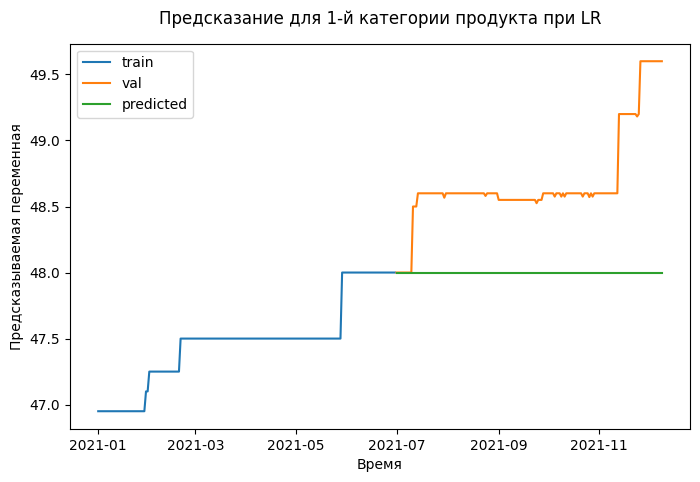

In [ ]:
# определяем простейшую модель
linear_forecaster = ForecasterAutoreg(
    regressor=LinearRegression(),
    lags=len(val_1)
)

# обучаем модель
linear_forecaster.fit(train_1)

# строим прогноз
predictions_1 = linear_forecaster.predict(len(val_1))
predictions_1.index = val_1.index

# печатаем метрики
print(f"MAPE = {mean_absolute_percentage_error(val_1, predictions_1)}")
print(f"MAE = {mean_absolute_error(val_1, predictions_1)}")
print(f"MSE = {mean_squared_error(val_1, predictions_1)}")
print(f"R^2 = {r2_score(val_1, predictions_1)}")
print('')

# строим графики
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.plot(train_1, label='train')
ax.plot(val_1, label='val')
ax.plot(predictions_1, label='predicted')
ax.set_xlabel('Время')
ax.set_ylabel('Предсказываемая переменная')
plt.title(label='Предсказание для 1-й категории продукта при LR', y=1.03)
plt.legend()
plt.show()

In [ ]:
# создадим pipeline для обработки
pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('model', CatBoostRegressor(random_seed=123, verbose=False))
])

catboost_forecaster = ForecasterAutoreg(
    regressor=pipe,
    lags=1 # Этот параметр будет меняться, поэтому можно поставить его каким угодно
)

param_grid = {
    'model__n_estimators': [30 ,50, 100, 200],
    'model__max_depth': [3, 4, 5, 10]
}
# Теперь перетренируем линейную регрессию и catboost на всех обучающих данных и протестируем модели

linear_forecaster = ForecasterAutoreg(
    regressor=LinearRegression(),
    lags=12
)
linear_forecaster.fit(pd.concat([train_1, val_1]))
lr_predictions_1 = linear_forecaster.predict(len(test_1))
lr_predictions_1.index = test_1.index

print(f"MAPE = {mean_absolute_percentage_error(test_1, lr_predictions_1)}")
print(f"MAE = {mean_absolute_error(test_1, lr_predictions_1)}")
print(f"MSE = {mean_squared_error(test_1, lr_predictions_1)}")
print(f"R^2 = {r2_score(test_1, lr_predictions_1)}")

MAPE = 0.03432821642509326
MAE = 1.7850049702793533
MSE = 3.310329111758119
R^2 = -9818.62262822994


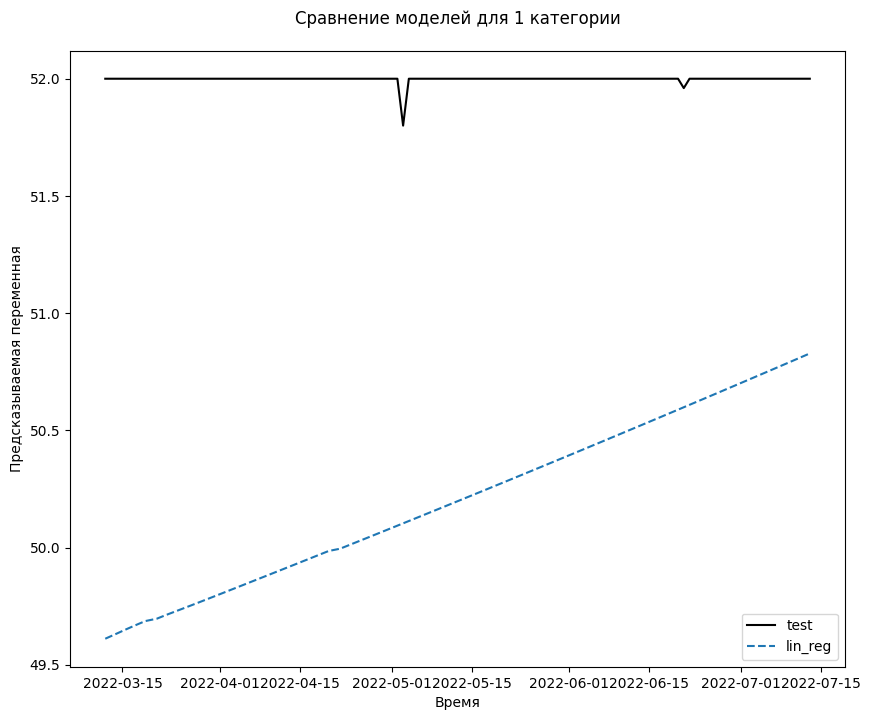

In [ ]:
# построим график сравнения прогнозов моделей
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.plot(test_1, label='test', c='black')
ax.plot(lr_predictions_1, label='lin_reg', ls='--')
# ax.plot(cb_predictions_1, label='Catboost', ls='--')

ax.set_xlabel('Время')
ax.set_ylabel('Предсказываемая переменная')
ax.set_title('Сравнение моделей для 1 категории', y=1.03)
plt.legend()
plt.show()

Catboost по первой категории построить не удалось.

# 2 категория продукта

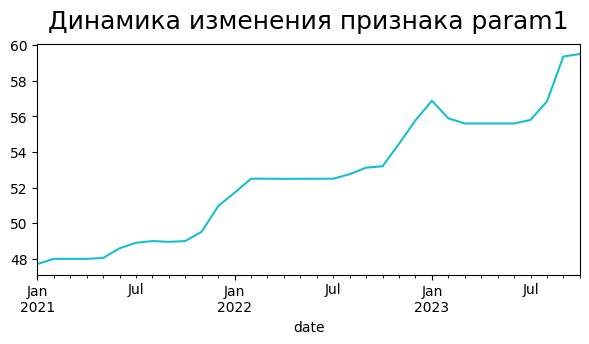

In [ ]:
# посмотрим динамику изменения признака param1 по месяцам представленных лет для param2 = 2
vis(df_2)

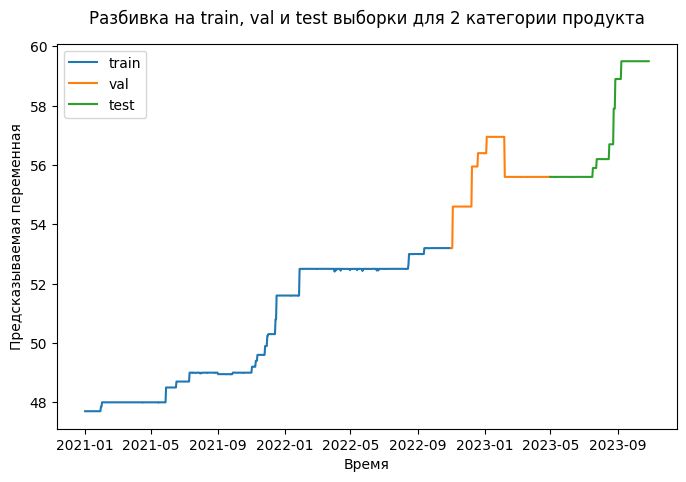

In [ ]:
# построим графики разбивки train, val и test выборки
# для 2 категории

# отрисуем данные для диапазона значений по всем категориям продуктов
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.plot(train.param1.loc[train["param2"] == 2], label='train')
ax.plot(val.param1.loc[val["param2"] == 2], label='val')
ax.plot(test.param1.loc[test["param2"] == 2], label='test')
ax.set_xlabel('Время')
ax.set_ylabel('Предсказываемая переменная')
plt.title(label='Разбивка на train, val и test выборки для 2 категории продукта', y=1.03)
plt.legend()
plt.show()

In [ ]:
# разделим наши данные на train, val и test выборки
train_2 = train.param1.loc[train["param2"] == 2]
val_2 = val.param1.loc[val["param2"] == 2]
test_2 = test.param1.loc[test["param2"] == 2]

print('Обучающая выборка для 2 категории имеет размер:     ', len(train_2))
print('Валидационная выборка для 2 категории имеет размер: ', len(val_2))
print('Тестовая выборка для 2 категории имеет размер:      ', len(test_2))

Обучающая выборка для 2 категории имеет размер:      668
Валидационная выборка для 2 категории имеет размер:  181
Тестовая выборка для 2 категории имеет размер:       181


In [ ]:
# определяем простейшую модель
linear_forecaster = ForecasterAutoreg(
    regressor=LinearRegression(),
    lags=len(val_2)
)

# обучаем модель
linear_forecaster.fit(train_2)

# строим прогноз
predictions_2 = linear_forecaster.predict(len(val_2))
predictions_2.index = val_2.index

# печатаем метрики
print(f"MAPE = {mean_absolute_percentage_error(val_2, predictions_2)}")
print(f"MAE = {mean_absolute_error(val_2, predictions_2)}")
print(f"MSE = {mean_squared_error(val_2, predictions_2)}")
print(f"R^2 = {r2_score(val_2, predictions_2)}")

MAPE = 0.040605498441589234
MAE = 2.273386466734353
MSE = 5.89458006680528
R^2 = -7.744444591637867


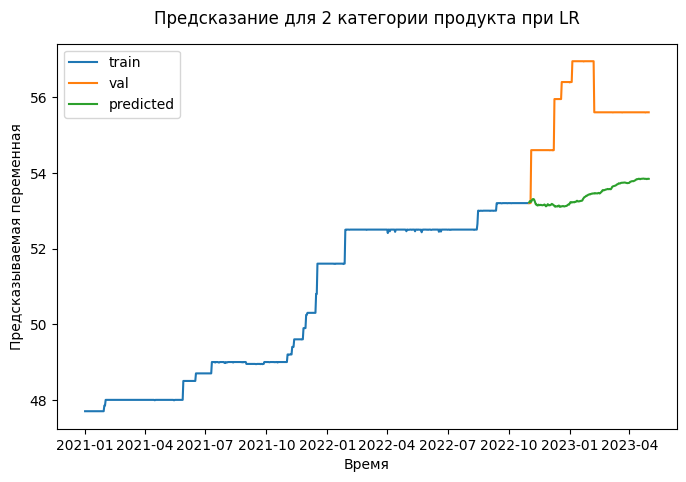

In [ ]:
# строим графики
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.plot(train_2, label='train')
ax.plot(val_2, label='val')
ax.plot(predictions_2, label='predicted')
ax.set_xlabel('Время')
ax.set_ylabel('Предсказываемая переменная')
plt.title(label='Предсказание для 2 категории продукта при LR', y=1.03)
plt.legend()
plt.show()

In [ ]:
# посмотрим влияние параметров в модели
linear_forecaster.get_feature_importances()

,feature,importance
0,lag_1,0.945053
1,lag_2,0.216116
2,lag_3,-0.152973
3,lag_4,-0.006956
4,lag_5,-0.000522
...,...,...
176,lag_177,0.001079
177,lag_178,0.031922
178,lag_179,-0.034237
179,lag_180,-0.034973


In [ ]:
# посмотрим прогноз с моделью CatBoostRegressor
catboost_forecaster = ForecasterAutoreg(
    regressor=CatBoostRegressor(random_seed=123, verbose=False),
    lags=len(val_2)
)
catboost_forecaster.fit(train_2)
predictions_2 = catboost_forecaster.predict(len(val_2))
predictions_2.index = val_2.index

print(f"MAPE = {mean_absolute_percentage_error(val_2, predictions_2)}")
print(f"MAE = {mean_absolute_error(val_2, predictions_2)}")
print(f"MSE = {mean_squared_error(val_2, predictions_2)}")
print(f"R^2 = {r2_score(val_2, predictions_2)}")

MAPE = 0.044547018895583934
MAE = 2.4929990829018283
MSE = 6.879223932178147
R^2 = -9.20513621439424


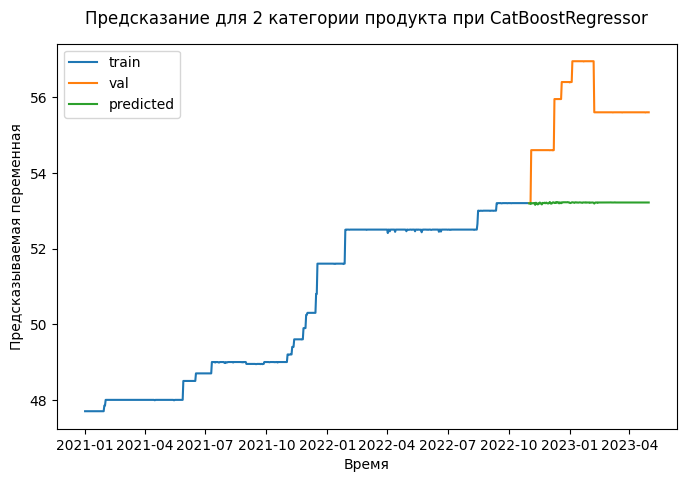

In [ ]:
# строим графики
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.plot(train_2, label='train')
ax.plot(val_2, label='val')
ax.plot(predictions_2, label='predicted')
ax.set_xlabel('Время')
ax.set_ylabel('Предсказываемая переменная')
plt.title(label='Предсказание для 2 категории продукта при CatBoostRegressor', y=1.03)
plt.legend()
plt.show()

In [ ]:
# преобразуем параметр y для подбора параметров
y = df_2.loc[:test_start, 'param1']
y.reset_index(drop= True , inplace= True )

# проверим тип и индексы для y
print(type(y))
print(y)

<class 'pandas.core.series.Series'>
0      47.7
1      47.7
2      47.7
3      47.7
4      47.7
       ... 
845    55.6
846    55.6
847    55.6
848    55.6
849    55.6
Name: param1, Length: 850, dtype: float64


In [ ]:
# подберем параметры

catboost_forecaster = ForecasterAutoreg(
    regressor=CatBoostRegressor(random_seed=123, verbose=False),
    lags=1 # Этот параметр будет меняться, поэтому можно поставить его каким угодно
)

lags_grid = [6, 12, [1, 2, 3, 6, 12]] # задаем сетку лагов

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15]
}
# Все параметры можно найти в документации, пройдемся по главным:
# forecaster - модель
# y - данные на которых мы хотим учиться
# param_grid, lags_grid - параметры, которые мы хотим тюнить
# steps - горизонт предсказания, на котором мы хотим валидироваться,  нашем случае - len(train_2)
# initial_train_size - тренировочные данные,  нашем случае - len(train_2)

# Возвращаемое значение - DataFrame с параметрами и результатом тестирования
results_grid = grid_search_forecaster(
                   forecaster         = catboost_forecaster,
                   y                  = y,
                   param_grid         = param_grid,
                   lags_grid          = lags_grid,
                   steps              = len(val_2),
                   refit              = False,
                   metric             = 'mean_absolute_percentage_error',
                   initial_train_size = len(df_2.loc[:val_start]),
                   fixed_train_size   = False,
                   return_best        = True,
                   n_jobs             = 'auto',
                   verbose            = False,
                   show_progress      = False
               )
results_grid = results_grid.reset_index()

Number of models compared: 27.
`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  6 12] 
  Parameters: {'max_depth': 5, 'n_estimators': 50}
  Backtesting metric: 0.04487568387717926



На валидации Catboost показал себя лучше, MAPE=0.045

In [ ]:
# создадим pipeline для обработки для LR
pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('model', CatBoostRegressor(random_seed=123, verbose=False))
])

catboost_forecaster = ForecasterAutoreg(
    regressor=pipe,
    lags=1 # Этот параметр будет меняться, поэтому можно поставить его каким угодно
)

param_grid = {
    'model__n_estimators': [30 ,50, 100, 200],
    'model__max_depth': [3, 4, 5, 10]
}
# Теперь перетренируем линейную регрессию и catboost на всех обучающих данных и протестируем модели

linear_forecaster = ForecasterAutoreg(
    regressor=LinearRegression(),
    lags=12
)
linear_forecaster.fit(pd.concat([train_2, val_2]))
lr_predictions_2 = linear_forecaster.predict(len(test_2))
lr_predictions_2.index = test_2.index

print(f"MAPE = {mean_absolute_percentage_error(test_2, lr_predictions_2)}")
print(f"MAE = {mean_absolute_error(test_2, lr_predictions_2)}")
print(f"MSE = {mean_squared_error(test_2, lr_predictions_2)}")
print(f"R^2 = {r2_score(test_2, lr_predictions_2)}")

MAPE = 0.019475481114792182
MAE = 1.1473048084207418
MSE = 2.919718061397357
R^2 = 0.015453506956397134


In [ ]:
# создадим pipeline для обработки для CB
pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('model', CatBoostRegressor(**{'max_depth': 5, 'n_estimators': 50}, random_seed=123, verbose=False))
])
catboost_forecaster = ForecasterAutoreg(
    regressor=pipe,
    lags=[1, 2, 3, 6, 12]
)

catboost_forecaster.fit(pd.concat([train_2, val_2]))
cb_predictions_2  = catboost_forecaster.predict(len(test_2))
cb_predictions_2.index = test_2.index

print(f"MAPE = {mean_absolute_percentage_error(test_2, cb_predictions_2)}")
print(f"MAE = {mean_absolute_error(test_2, cb_predictions_2)}")
print(f"MSE = {mean_squared_error(test_2, cb_predictions_2)}")
print(f"R^2 = {r2_score(test_2, cb_predictions_2)}")

MAPE = 0.024954167783829497
MAE = 1.4740115400822558
MSE = 5.133324564170878
R^2 = -0.7309879211043449


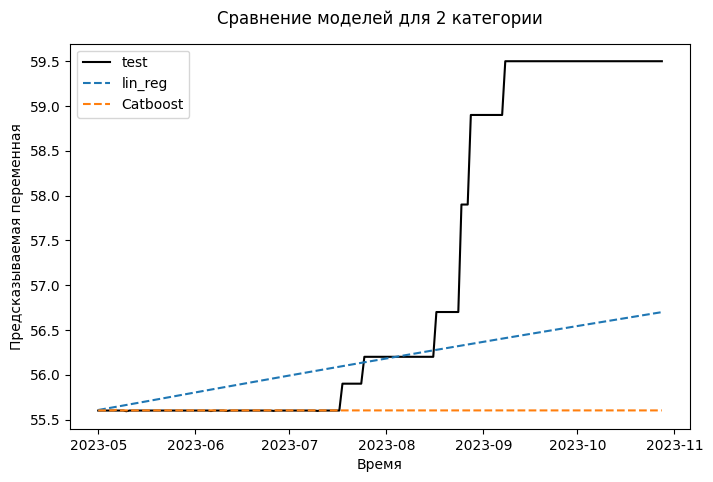

In [ ]:
# построим график сравнения прогнозов моделей
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.plot(test_2, label='test', c='black')
ax.plot(lr_predictions_2, label='lin_reg', ls='--')
ax.plot(cb_predictions_2, label='Catboost', ls='--')


ax.set_xlabel('Время')
ax.set_ylabel('Предсказываемая переменная')
ax.set_title('Сравнение моделей для 2 категории', y=1.03)
plt.legend()
plt.show()

По категории 2 видим, что линейная регрессия отрабатывает более приближенно к тестовой выборке

# 3 категория продукта

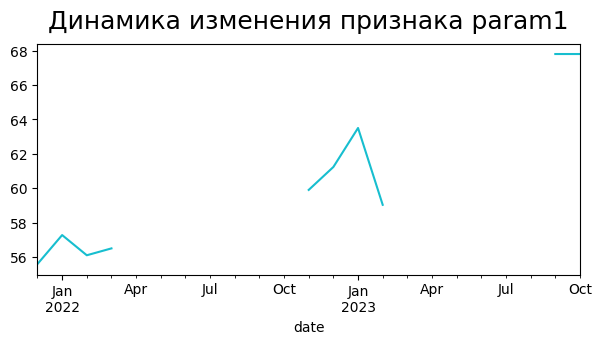

In [ ]:
# посмотрим динамику изменения признака param1 по месяцам представленных лет для param2 = 3
vis(df_3)

 Товар в данной категории реализуется сезонно, только в зимние периоды каждого года.

Обучающая выборка для 3 категории имеет размер:      36
Валидационная выборка для 3 категории имеет размер:  1
Тестовая выборка для 3 категории имеет размер:       171



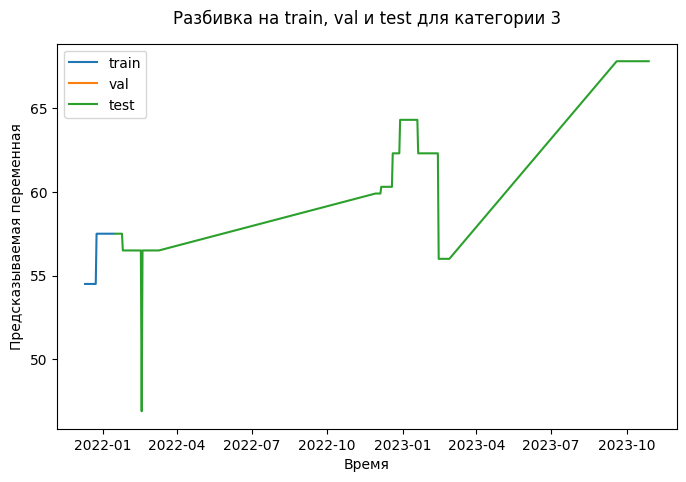

In [ ]:
# определим границы наших выборок по дате
val_start_3 = pd.to_datetime('2022-01-15')
test_start_3 = pd.to_datetime('2022-01-16')

# разделим наши данные на train, val и test выборки
train_3 = df_3[df_3.index < val_start_3]
train_3 = train_3.loc[:,'param1']

val_3 = df_3[(df_3.index >= val_start_3) & (df_3.index < test_start_3)]
val_3 = val_3.loc[:,'param1']

test_3 = df_3[(df_3.index >= test_start_3)]
test_3 = test_3.loc[:,'param1']


print('Обучающая выборка для 3 категории имеет размер:     ', len(train_3))
print('Валидационная выборка для 3 категории имеет размер: ', len(val_3))
print('Тестовая выборка для 3 категории имеет размер:      ', len(test_3))
print('')

# отрисуем данные для диапазона значений по всем категориям продуктов
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.plot(train_3, label='train')
ax.plot(val_3, label='val')
ax.plot(test_3, label='test')
ax.set_xlabel('Время')
ax.set_ylabel('Предсказываемая переменная')
plt.title(label='Разбивка на train, val и test для категории 3', y=1.03)
plt.legend()
plt.show()

MAPE = 0.0
MAE = 0.0
MSE = 0.0
R^2 = nan



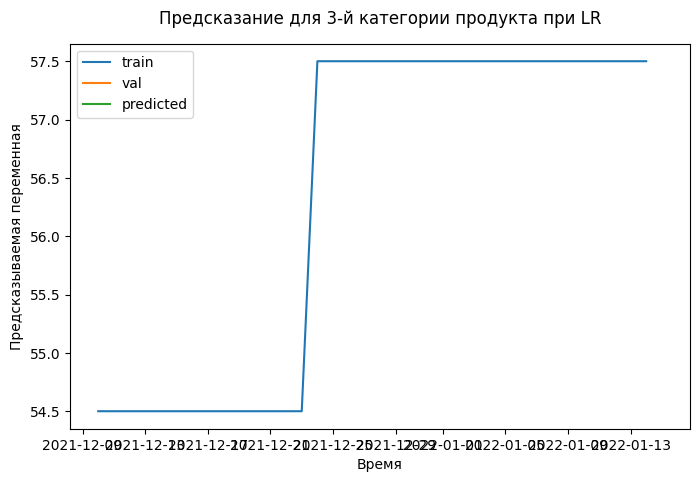

In [ ]:
# определяем простейшую модель
linear_forecaster = ForecasterAutoreg(
    regressor=LinearRegression(),
    lags=1
)

# обучаем модель
linear_forecaster.fit(train_3)

# строим прогноз
predictions_3 = linear_forecaster.predict(len(val_3))
predictions_3.index = val_3.index

# печатаем метрики
print(f"MAPE = {mean_absolute_percentage_error(val_3, predictions_3)}")
print(f"MAE = {mean_absolute_error(val_3, predictions_3)}")
print(f"MSE = {mean_squared_error(val_3, predictions_3)}")
print(f"R^2 = {r2_score(val_3, predictions_3)}")
print('')

# строим графики
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.plot(train_3, label='train')
ax.plot(val_3, label='val')
ax.plot(predictions_3, label='predicted')
ax.set_xlabel('Время')
ax.set_ylabel('Предсказываемая переменная')
plt.title(label='Предсказание для 3-й категории продукта при LR', y=1.03)
plt.legend()
plt.show()

In [ ]:
# создадим pipeline для обработки
pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('model', CatBoostRegressor(random_seed=123, verbose=False))
])

catboost_forecaster = ForecasterAutoreg(
    regressor=pipe,
    lags=1 # Этот параметр будет меняться, поэтому можно поставить его каким угодно
)

param_grid = {
    'model__n_estimators': [30 ,50, 100, 200],
    'model__max_depth': [3, 4, 5, 10]
}
# Теперь перетренируем линейную регрессию и catboost на всех обучающих данных и протестируем модели

linear_forecaster = ForecasterAutoreg(
    regressor=LinearRegression(),
    lags=12
)
linear_forecaster.fit(pd.concat([train_3, val_3]))
lr_predictions_3 = linear_forecaster.predict(len(test_3))
lr_predictions_3.index = test_3.index

print(f"MAPE = {mean_absolute_percentage_error(test_3, lr_predictions_3)}")
print(f"MAE = {mean_absolute_error(test_3, lr_predictions_3)}")
print(f"MSE = {mean_squared_error(test_3, lr_predictions_3)}")
print(f"R^2 = {r2_score(test_3, lr_predictions_3)}")

MAPE = 0.07270026802123142
MAE = 4.664327485380104
MSE = 34.478011695906126
R^2 = -0.7705926777585814


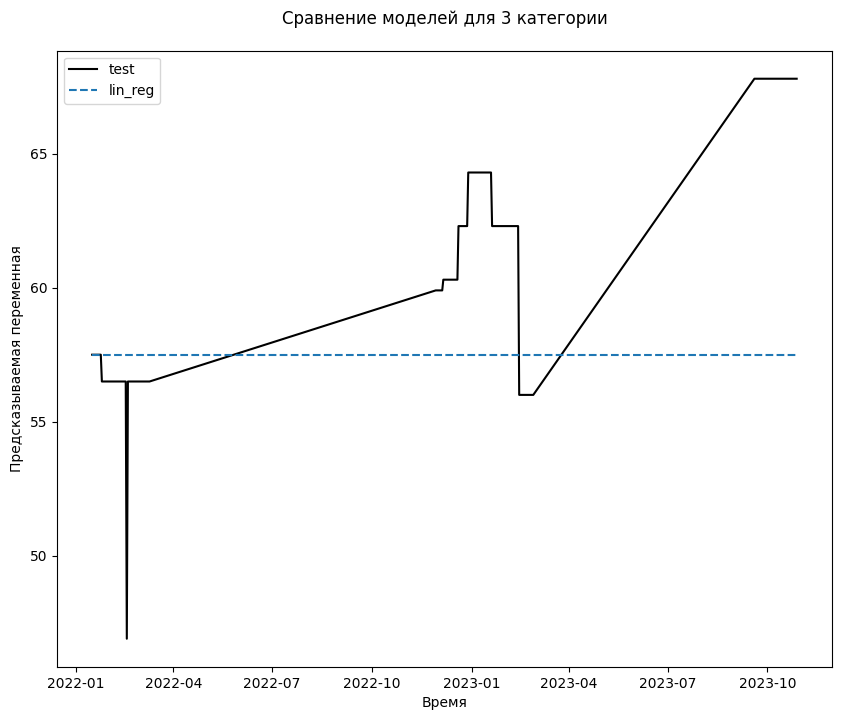

In [ ]:
# построим график сравнения прогнозов моделей
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.plot(test_3, label='test', c='black')
ax.plot(lr_predictions_3, label='lin_reg', ls='--')
# ax.plot(cb_predictions_1, label='Catboost', ls='--')

ax.set_xlabel('Время')
ax.set_ylabel('Предсказываемая переменная')
ax.set_title('Сравнение моделей для 3 категории', y=1.03)
plt.legend()
plt.show()

Как видно из графиков линейная регрессия в случае с сезоннынми товарами показывает не самые лучшие результаты.

# 4 категория продукта

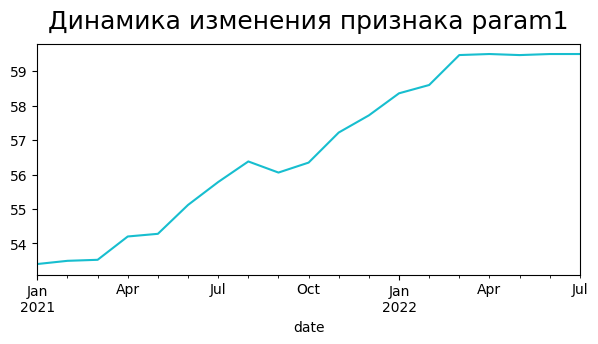

In [ ]:
# посмотрим динамику изменения признака param1 по месяцам представленных лет для param2 = 4
vis(df_4)

Обучающая выборка для 3 категории имеет размер:      304
Валидационная выборка для 3 категории имеет размер:  151
Тестовая выборка для 3 категории имеет размер:       95



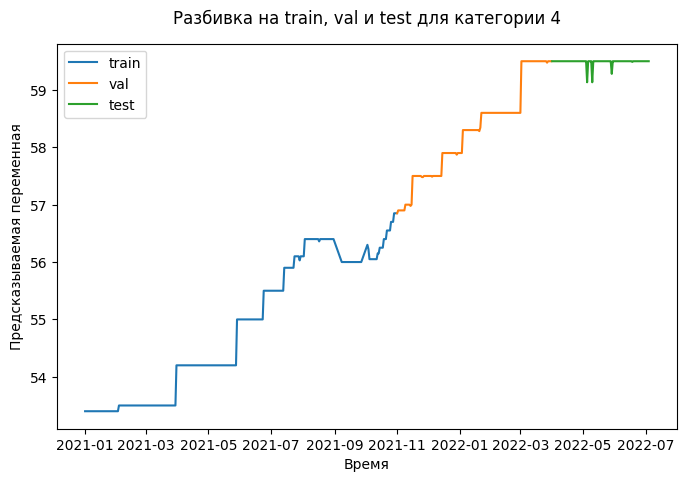

In [ ]:
# определим границы наших выборок по дате
val_start_4 = pd.to_datetime('2021-11-01')
test_start_4 = pd.to_datetime('2022-04-01')


# разделим наши данные на train, val и test выборки
train_4 = df_4[df_4.index < val_start_4]
train_4 = train_4.loc[:,'param1']

val_4 = df_4[(df_4.index >= val_start_4) & (df_4.index < test_start_4)]
val_4 = val_4.loc[:,'param1']

test_4 = df_4[(df_4.index >= test_start_4)]
test_4 = test_4.loc[:,'param1']


print('Обучающая выборка для 3 категории имеет размер:     ', len(train_4))
print('Валидационная выборка для 3 категории имеет размер: ', len(val_4))
print('Тестовая выборка для 3 категории имеет размер:      ', len(test_4))
print('')

# отрисуем данные для диапазона значений по всем категориям продуктов
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.plot(train_4, label='train')
ax.plot(val_4, label='val')
ax.plot(test_4, label='test')
ax.set_xlabel('Время')
ax.set_ylabel('Предсказываемая переменная')
plt.title(label='Разбивка на train, val и test для категории 4', y=1.03)
plt.legend()
plt.show()

In [ ]:
# определяем простейшую модель
linear_forecaster = ForecasterAutoreg(
    regressor=LinearRegression(),
    lags=len(val_4)
)

# обучаем модель
linear_forecaster.fit(train_4)

# строим прогноз
predictions_4 = linear_forecaster.predict(len(val_4))
predictions_4.index = val_4.index

# печатаем метрики
print(f"MAPE = {mean_absolute_percentage_error(val_4, predictions_4)}")
print(f"MAE = {mean_absolute_error(val_4, predictions_4)}")
print(f"MSE = {mean_squared_error(val_4, predictions_4)}")
print(f"R^2 = {r2_score(val_4, predictions_4)}")

MAPE = 0.024917004551949735
MAE = 1.4598992822259307
MSE = 3.15518411235895
R^2 = -3.9564067490634036


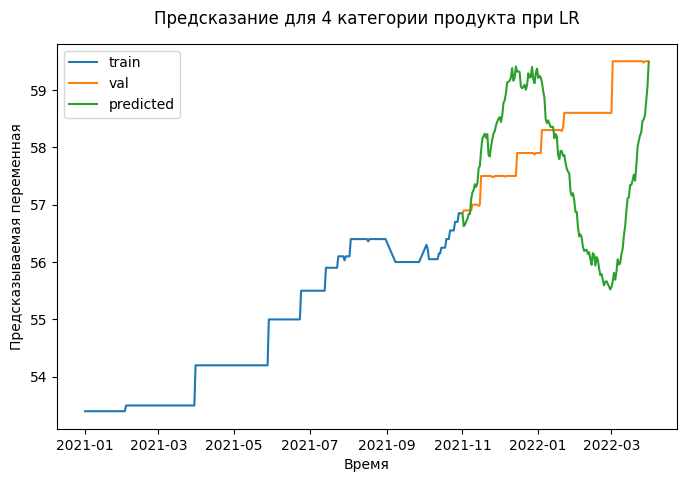

In [ ]:
# строим графики
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.plot(train_4, label='train')
ax.plot(val_4, label='val')
ax.plot(predictions_4, label='predicted')
ax.set_xlabel('Время')
ax.set_ylabel('Предсказываемая переменная')
plt.title(label='Предсказание для 4 категории продукта при LR', y=1.03)
plt.legend()
plt.show()

In [ ]:
# посмотрим прогноз с моделью CatBoostRegressor
catboost_forecaster = ForecasterAutoreg(
    regressor=CatBoostRegressor(random_seed=123, verbose=False),
    lags=5
)
catboost_forecaster.fit(train_4)
predictions_4 = catboost_forecaster.predict(len(val_4))
predictions_4.index = val_4.index

print(f"MAPE = {mean_absolute_percentage_error(val_4, predictions_4)}")
print(f"MAE = {mean_absolute_error(val_4, predictions_4)}")
print(f"MSE = {mean_squared_error(val_4, predictions_4)}")
print(f"R^2 = {r2_score(val_4, predictions_4)}")

MAPE = 0.02433673406335434
MAE = 1.4288430713489042
MSE = 2.678179524396527
R^2 = -3.207091122805523


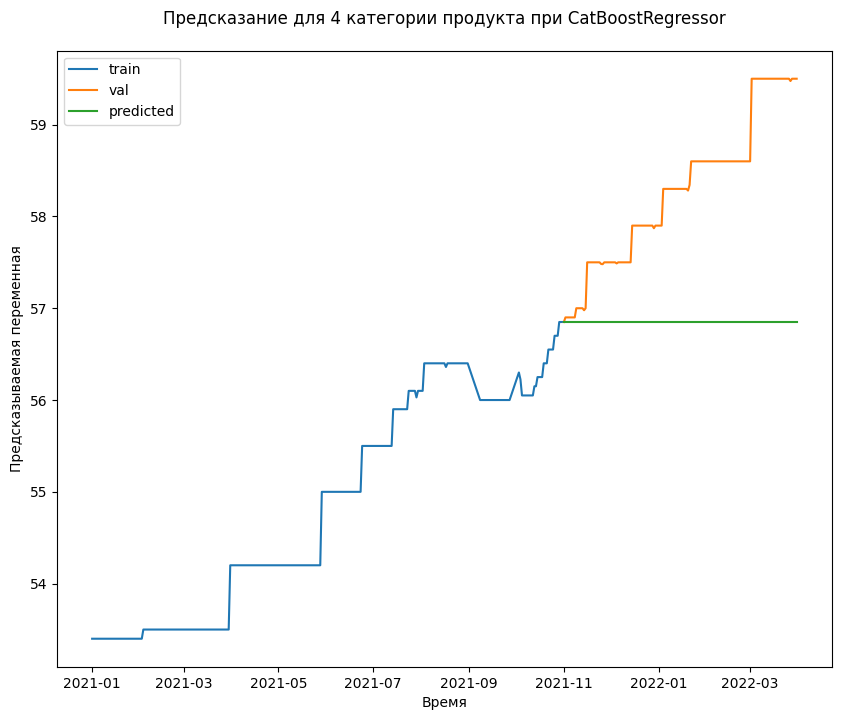

In [ ]:
# строим графики
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.plot(train_4, label='train')
ax.plot(val_4, label='val')
ax.plot(predictions_4, label='predicted')
ax.set_xlabel('Время')
ax.set_ylabel('Предсказываемая переменная')
plt.title(label='Предсказание для 4 категории продукта при CatBoostRegressor', y=1.03)
plt.legend()
plt.show()

In [ ]:
# создадим pipeline для обработки
pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('model', CatBoostRegressor(random_seed=123, verbose=False))
])

catboost_forecaster = ForecasterAutoreg(
    regressor=pipe,
    lags=1 # Этот параметр будет меняться, поэтому можно поставить его каким угодно
)

param_grid = {
    'model__n_estimators': [30 ,50, 100, 200],
    'model__max_depth': [3, 4, 5, 10]
}
# Теперь перетренируем линейную регрессию и catboost на всех обучающих данных и протестируем модели

linear_forecaster = ForecasterAutoreg(
    regressor=LinearRegression(),
    lags=12
)
linear_forecaster.fit(pd.concat([train_4, val_4]))
lr_predictions_4 = linear_forecaster.predict(len(test_4))
lr_predictions_4.index = test_4.index

print(f"MAPE = {mean_absolute_percentage_error(test_4, lr_predictions_4)}")
print(f"MAE = {mean_absolute_error(test_4, lr_predictions_4)}")
print(f"MSE = {mean_squared_error(test_4, lr_predictions_4)}")
print(f"R^2 = {r2_score(test_4, lr_predictions_4)}")

MAPE = 0.014111160368292954
MAE = 0.8394309595147296
MSE = 0.9293273264222389
R^2 = -285.9945163778075


In [ ]:
pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('model', CatBoostRegressor(**{'max_depth': 5, 'n_estimators': 50}, random_seed=123, verbose=False))
])
catboost_forecaster = ForecasterAutoreg(
    regressor=pipe,
    lags=[1, 2, 3, 6, 12]
)

catboost_forecaster.fit(pd.concat([train_4, val_4]))
cb_predictions_4  = catboost_forecaster.predict(len(test_4))
cb_predictions_4.index = test_4.index

print(f"MAPE = {mean_absolute_percentage_error(test_4, cb_predictions_4)}")
print(f"MAE = {mean_absolute_error(test_4, cb_predictions_4)}")
print(f"MSE = {mean_squared_error(test_4, cb_predictions_4)}")
print(f"R^2 = {r2_score(test_4, cb_predictions_4)}")

MAPE = 0.0001978331302252988
MAE = 0.011714320484437067
MSE = 0.0033753614825920613
R^2 = -0.042377867038696504


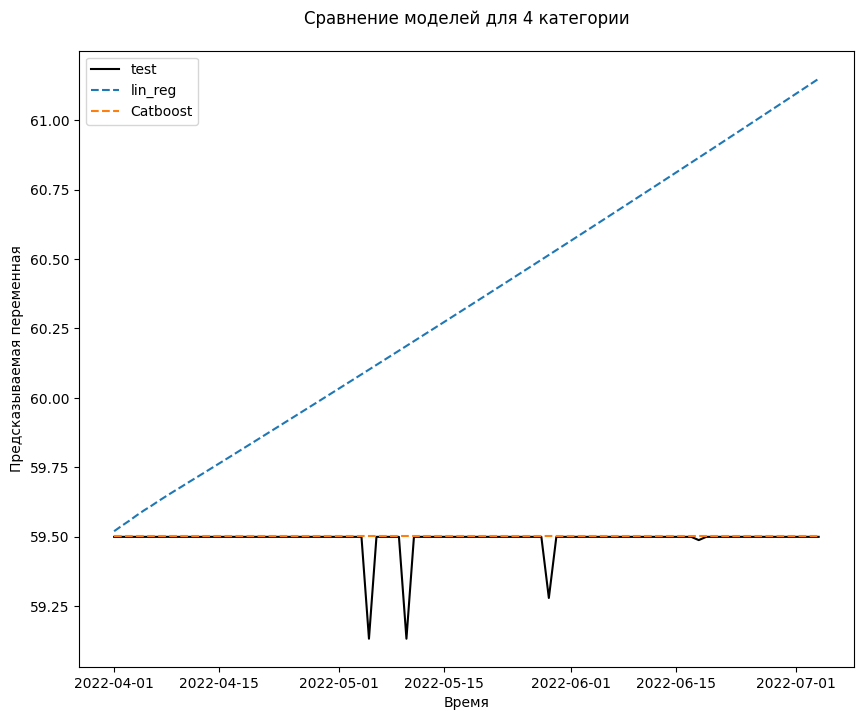

In [ ]:
# построим график сравнения прогнозов моделей
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.plot(test_4, label='test', c='black')
ax.plot(lr_predictions_4, label='lin_reg', ls='--')
ax.plot(cb_predictions_4, label='Catboost', ls='--')

ax.set_xlabel('Время')
ax.set_ylabel('Предсказываемая переменная')
ax.set_title('Сравнение моделей для 4 категории', y=1.03)
plt.legend()
plt.show()

По 4-й категории товара линейная регрессия также справилась лучше чем catboost.

# 5 категория продукта

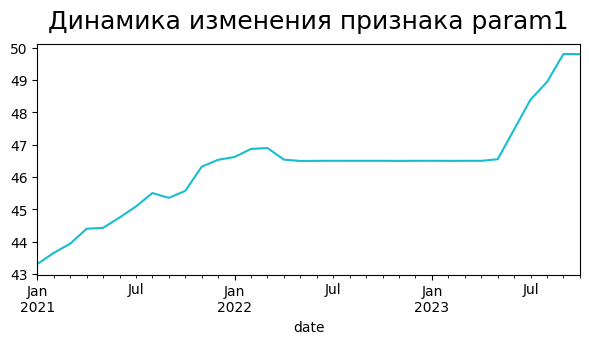

In [ ]:
# посмотрим динамику изменения признака param1 по месяцам представленных лет для param2 = 5
vis(df_5)

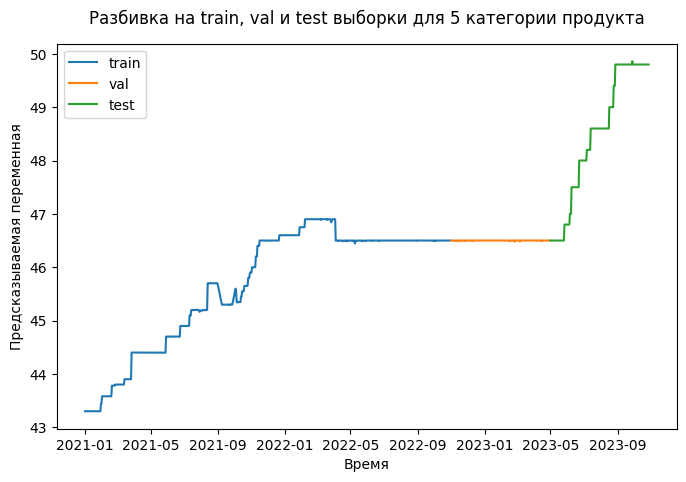

In [ ]:
# построим графики разбивки train, val и test выборки
# для 5 категории

# отрисуем данные для диапазона значений по всем категориям продуктов
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.plot(train.param1.loc[train["param2"] == 5], label='train')
ax.plot(val.param1.loc[val["param2"] == 5], label='val')
ax.plot(test.param1.loc[test["param2"] == 5], label='test')
ax.set_xlabel('Время')
ax.set_ylabel('Предсказываемая переменная')
plt.title(label='Разбивка на train, val и test выборки для 5 категории продукта', y=1.03)
plt.legend()
plt.show()

In [ ]:
# разделим наши данные на train, val и test выборки
train_5 = train.param1.loc[train["param2"] == 5]
val_5 = val.param1.loc[val["param2"] == 5]
test_5 = test.param1.loc[test["param2"] == 5]

print('Обучающая выборка для 5 категории имеет размер:     ', len(train_5))
print('Валидационная выборка для 5 категории имеет размер: ', len(val_5))
print('Тестовая выборка для 5 категории имеет размер:      ', len(test_5))

Обучающая выборка для 5 категории имеет размер:      668
Валидационная выборка для 5 категории имеет размер:  181
Тестовая выборка для 5 категории имеет размер:       181


In [ ]:
# определяем простейшую модель
linear_forecaster = ForecasterAutoreg(
    regressor=LinearRegression(),
    lags=len(val_5)
)

# обучаем модель
linear_forecaster.fit(train_5)

# строим прогноз
predictions_5 = linear_forecaster.predict(len(val_5))
predictions_5.index = val_5.index

# печатаем метрики
print(f"MAPE = {mean_absolute_percentage_error(val_5, predictions_5)}")
print(f"MAE = {mean_absolute_error(val_5, predictions_5)}")
print(f"MSE = {mean_squared_error(val_5, predictions_5)}")
print(f"R^2 = {r2_score(val_5, predictions_5)}")

MAPE = 0.0013101001843643229
MAE = 0.06091869720907849
MSE = 0.004552752583307036
R^2 = -501.34680597632996


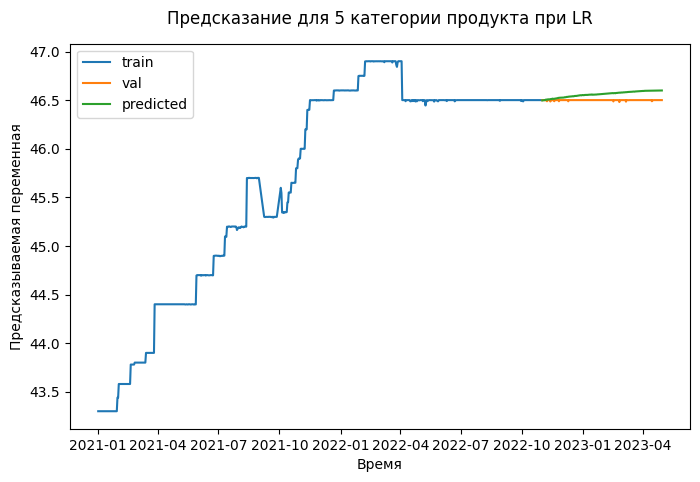

In [ ]:
# строим графики
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.plot(train_5, label='train')
ax.plot(val_5, label='val')
ax.plot(predictions_5, label='predicted')
ax.set_xlabel('Время')
ax.set_ylabel('Предсказываемая переменная')
plt.title(label='Предсказание для 5 категории продукта при LR', y=1.03)
plt.legend()
plt.show()

In [ ]:
# посмотрим прогноз с моделью CatBoostRegressor
catboost_forecaster = ForecasterAutoreg(
    regressor=CatBoostRegressor(random_seed=123, verbose=False),
    lags=5
)
catboost_forecaster.fit(train_5)
predictions_5 = catboost_forecaster.predict(len(val_5))
predictions_5.index = val_5.index

print(f"MAPE = {mean_absolute_percentage_error(val_5, predictions_5)}")
print(f"MAE = {mean_absolute_error(val_5, predictions_5)}")
print(f"MSE = {mean_squared_error(val_5, predictions_5)}")
print(f"R^2 = {r2_score(val_5, predictions_5)}")

MAPE = 5.799827432539639e-05
MAE = 0.002696682907118227
MSE = 1.6335065817376247e-05
R^2 = -0.8023971188022463


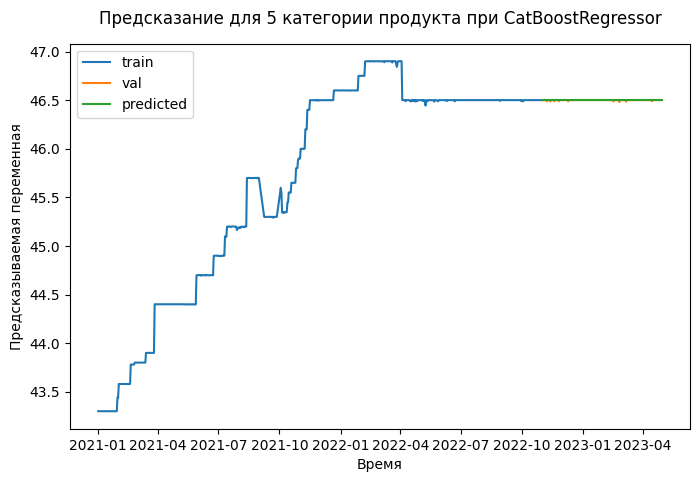

In [ ]:
# строим графики
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.plot(train_5, label='train')
ax.plot(val_5, label='val')
ax.plot(predictions_5, label='predicted')
ax.set_xlabel('Время')
ax.set_ylabel('Предсказываемая переменная')
plt.title(label='Предсказание для 5 категории продукта при CatBoostRegressor', y=1.03)
plt.legend()
plt.show()

In [ ]:
# преобразуем параметр y для подбора параметров
y = df_5.loc[:test_start, 'param1']
y.reset_index(drop= True , inplace= True )

# проверим тип и индексы для y
print(type(y))
print(y)

<class 'pandas.core.series.Series'>
0      43.3
1      43.3
2      43.3
3      43.3
4      43.3
       ... 
845    46.5
846    46.5
847    46.5
848    46.5
849    46.5
Name: param1, Length: 850, dtype: float64


In [ ]:
# подберем параметры

catboost_forecaster = ForecasterAutoreg(
    regressor=CatBoostRegressor(random_seed=123, verbose=False),
    lags=1 # Этот параметр будет меняться, поэтому можно поставить его каким угодно
)

lags_grid = [6, 12, [1, 2, 3, 6, 12]] # задаем сетку лагов

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15]
}
# Все параметры можно найти в документации, пройдемся по главным:
# forecaster - модель
# y - данные на которых мы хотим учиться
# param_grid, lags_grid - параметры, которые мы хотим тюнить
# steps - горизонт предсказания, на котором мы хотим валидироваться,  нашем случае - len(train_2)
# initial_train_size - тренировочные данные,  нашем случае - len(train_2)

# Возвращаемое значение - DataFrame с параметрами и результатом тестирования
results_grid = grid_search_forecaster(
                   forecaster         = catboost_forecaster,
                   y                  = y,
                   param_grid         = param_grid,
                   lags_grid          = lags_grid,
                   steps              = len(val_5),
                   refit              = False,
                   metric             = 'mean_absolute_percentage_error',
                   initial_train_size = len(df_5.loc[:val_start]),
                   fixed_train_size   = False,
                   return_best        = True,
                   n_jobs             = 'auto',
                   verbose            = False,
                   show_progress      = False
               )
results_grid = results_grid.reset_index()

Number of models compared: 27.
`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6] 
  Parameters: {'max_depth': 15, 'n_estimators': 100}
  Backtesting metric: 1.5619402983085365e-05



In [ ]:
# создадим pipeline для обработки
pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('model', CatBoostRegressor(random_seed=123, verbose=False))
])

catboost_forecaster = ForecasterAutoreg(
    regressor=pipe,
    lags=1 # Этот параметр будет меняться, поэтому можно поставить его каким угодно
)

param_grid = {
    'model__n_estimators': [30 ,50, 100],
    'model__max_depth': [3, 4, 5, 10, 15]
}
# Теперь перетренируем линейную регрессию и catboost на всех обучающих данных и протестируем модели

linear_forecaster = ForecasterAutoreg(
    regressor=LinearRegression(),
    lags=12
)
linear_forecaster.fit(pd.concat([train_5, val_5]))
lr_predictions_5 = linear_forecaster.predict(len(test_5))
lr_predictions_5.index = test_5.index

print(f"MAPE = {mean_absolute_percentage_error(test_5, lr_predictions_5)}")
print(f"MAE = {mean_absolute_error(test_5, lr_predictions_5)}")
print(f"MSE = {mean_squared_error(test_5, lr_predictions_5)}")
print(f"R^2 = {r2_score(test_5, lr_predictions_5)}")

MAPE = 0.03859375742580448
MAE = 1.8990662535474638
MSE = 4.983573453343272
R^2 = -2.3741730162486383


In [ ]:
pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('model', CatBoostRegressor(**{'max_depth': 5, 'n_estimators': 50}, random_seed=123, verbose=False))
])
catboost_forecaster = ForecasterAutoreg(
    regressor=pipe,
    lags=[1, 2, 3, 6, 12]
)

catboost_forecaster.fit(pd.concat([train_5, val_5]))
cb_predictions_5  = catboost_forecaster.predict(len(test_5))
cb_predictions_5.index = test_5.index

print(f"MAPE = {mean_absolute_percentage_error(test_5, cb_predictions_5)}")
print(f"MAE = {mean_absolute_error(test_5, cb_predictions_5)}")
print(f"MSE = {mean_squared_error(test_5, cb_predictions_5)}")
print(f"R^2 = {r2_score(test_5, cb_predictions_5)}")

MAPE = 0.03997170298430807
MAE = 1.9668573473519944
MSE = 5.344171789910488
R^2 = -2.6183193478599445


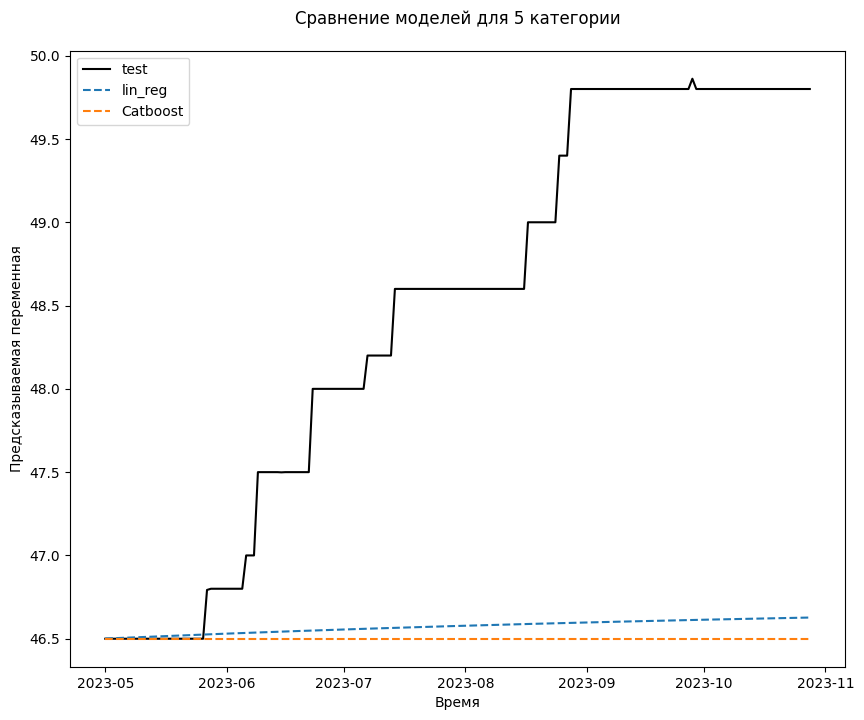

In [ ]:
# построим график сравнения прогнозов моделей
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.plot(test_5, label='test', c='black')
ax.plot(lr_predictions_5, label='lin_reg', ls='--')
ax.plot(cb_predictions_5, label='Catboost', ls='--')

ax.set_xlabel('Время')
ax.set_ylabel('Предсказываемая переменная')
ax.set_title('Сравнение моделей для 5 категории', y=1.03)
plt.legend()
plt.show()

В данной категории линейная регрессия также справилась лучше.

# 6 категория продукта

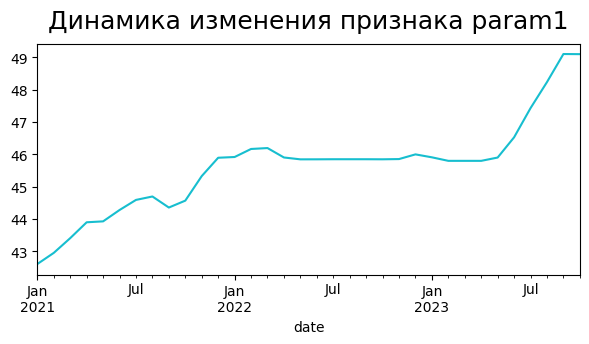

In [ ]:
# посмотрим динамику изменения признака param1 по месяцам представленных лет для param2 = 6
vis(df_6)

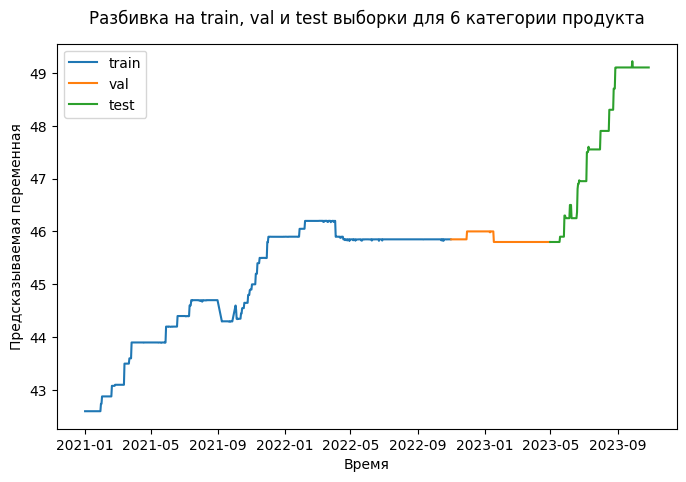

In [ ]:
# построим графики разбивки train, val и test выборки
# для 6 категории

# отрисуем данные для диапазона значений по всем категориям продуктов
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.plot(train.param1.loc[train["param2"] == 6], label='train')
ax.plot(val.param1.loc[val["param2"] == 6], label='val')
ax.plot(test.param1.loc[test["param2"] == 6], label='test')
ax.set_xlabel('Время')
ax.set_ylabel('Предсказываемая переменная')
plt.title(label='Разбивка на train, val и test выборки для 6 категории продукта', y=1.03)
plt.legend()
plt.show()

In [ ]:
# разделим наши данные на train, val и test выборки
train_6 = train.param1.loc[train["param2"] == 6]
val_6 = val.param1.loc[val["param2"] == 6]
test_6 = test.param1.loc[test["param2"] == 6]

print('Обучающая выборка для 6 категории имеет размер:     ', len(train_6))
print('Валидационная выборка для 6 категории имеет размер: ', len(val_6))
print('Тестовая выборка для 6 категории имеет размер:      ', len(test_6))

Обучающая выборка для 6 категории имеет размер:      668
Валидационная выборка для 6 категории имеет размер:  181
Тестовая выборка для 6 категории имеет размер:       181


In [ ]:
# определяем простейшую модель
linear_forecaster = ForecasterAutoreg(
    regressor=LinearRegression(),
    lags=len(val_6)
)

# обучаем модель
linear_forecaster.fit(train_6)

# строим прогноз
predictions_6 = linear_forecaster.predict(len(val_6))
predictions_6.index = val_6.index

# печатаем метрики
print(f"MAPE = {mean_absolute_percentage_error(val_6, predictions_6)}")
print(f"MAE = {mean_absolute_error(val_6, predictions_6)}")
print(f"MSE = {mean_squared_error(val_6, predictions_6)}")
print(f"R^2 = {r2_score(val_6, predictions_6)}")

MAPE = 0.0034859888847353394
MAE = 0.15970956133859449
MSE = 0.03801972056318701
R^2 = -4.178853730452437


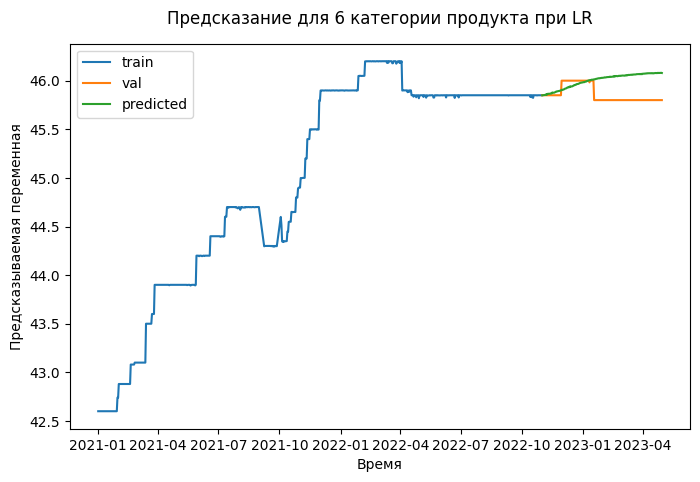

In [ ]:
# строим графики
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.plot(train_6, label='train')
ax.plot(val_6, label='val')
ax.plot(predictions_6, label='predicted')
ax.set_xlabel('Время')
ax.set_ylabel('Предсказываемая переменная')
plt.title(label='Предсказание для 6 категории продукта при LR', y=1.03)
plt.legend()
plt.show()

In [ ]:
# посмотрим прогноз с моделью CatBoostRegressor
catboost_forecaster = ForecasterAutoreg(
    regressor=CatBoostRegressor(random_seed=123, verbose=False),
    lags=5
)
catboost_forecaster.fit(train_6)
predictions_6 = catboost_forecaster.predict(len(val_6))
predictions_6.index = val_6.index

print(f"MAPE = {mean_absolute_percentage_error(val_6, predictions_6)}")
print(f"MAE = {mean_absolute_error(val_6, predictions_6)}")
print(f"MSE = {mean_squared_error(val_6, predictions_6)}")
print(f"R^2 = {r2_score(val_6, predictions_6)}")

MAPE = 0.0015193424120158755
MAE = 0.06976001280428056
MSE = 0.007447953524826777
R^2 = -0.014522498453950705


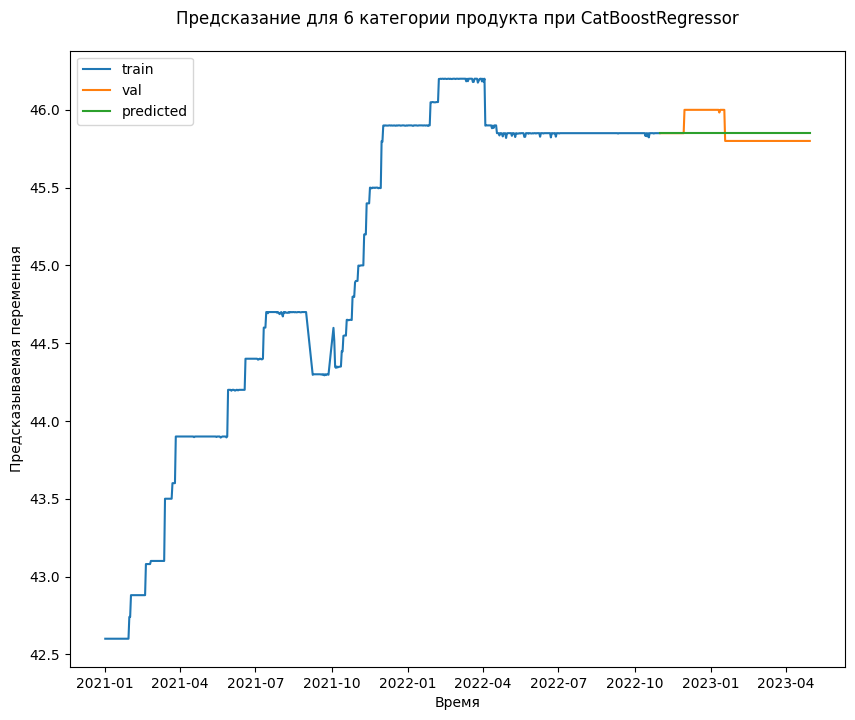

In [ ]:
# строим графики
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.plot(train_6, label='train')
ax.plot(val_6, label='val')
ax.plot(predictions_6, label='predicted')
ax.set_xlabel('Время')
ax.set_ylabel('Предсказываемая переменная')
plt.title(label='Предсказание для 6 категории продукта при CatBoostRegressor', y=1.03)
plt.legend()
plt.show()

In [ ]:
# преобразуем параметр y для подбора параметров
y = df_6.loc[:test_start, 'param1']
y.reset_index(drop= True , inplace= True )

# проверим тип и индексы для y
print(type(y))
print(y)

<class 'pandas.core.series.Series'>
0      42.6
1      42.6
2      42.6
3      42.6
4      42.6
       ... 
845    45.8
846    45.8
847    45.8
848    45.8
849    45.8
Name: param1, Length: 850, dtype: float64


In [ ]:
# подберем параметры

catboost_forecaster = ForecasterAutoreg(
    regressor=CatBoostRegressor(random_seed=123, verbose=False),
    lags=1 # Этот параметр будет меняться, поэтому можно поставить его каким угодно
)

lags_grid = [6, 12, [1, 2, 3, 6, 12]] # задаем сетку лагов

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15]
}
# Все параметры можно найти в документации, пройдемся по главным:
# forecaster - модель
# y - данные на которых мы хотим учиться
# param_grid, lags_grid - параметры, которые мы хотим тюнить
# steps - горизонт предсказания, на котором мы хотим валидироваться,  нашем случае - len(train_2)
# initial_train_size - тренировочные данные,  нашем случае - len(train_2)

# Возвращаемое значение - DataFrame с параметрами и результатом тестирования
results_grid = grid_search_forecaster(
                   forecaster         = catboost_forecaster,
                   y                  = y,
                   param_grid         = param_grid,
                   lags_grid          = lags_grid,
                   steps              = len(val_6),
                   refit              = False,
                   metric             = 'mean_absolute_percentage_error',
                   initial_train_size = len(df_6.loc[:val_start]),
                   fixed_train_size   = False,
                   return_best        = True,
                   n_jobs             = 'auto',
                   verbose            = False,
                   show_progress      = False
               )
results_grid = results_grid.reset_index()

Number of models compared: 27.
`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
  Parameters: {'max_depth': 5, 'n_estimators': 50}
  Backtesting metric: 0.0015028405549702697



In [ ]:
# создадим pipeline для обработки
pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('model', CatBoostRegressor(random_seed=123, verbose=False))
])

catboost_forecaster = ForecasterAutoreg(
    regressor=pipe,
    lags=1 # Этот параметр будет меняться, поэтому можно поставить его каким угодно
)

param_grid = {
    'model__n_estimators': [30 ,50],
    'model__max_depth': [3, 4, 5]
}
# Теперь перетренируем линейную регрессию и catboost на всех обучающих данных и протестируем модели

linear_forecaster = ForecasterAutoreg(
    regressor=LinearRegression(),
    lags=12
)
linear_forecaster.fit(pd.concat([train_6, val_6]))
lr_predictions_6 = linear_forecaster.predict(len(test_5))
lr_predictions_6.index = test_6.index

print(f"MAPE = {mean_absolute_percentage_error(test_6, lr_predictions_6)}")
print(f"MAE = {mean_absolute_error(test_6, lr_predictions_6)}")
print(f"MSE = {mean_squared_error(test_6, lr_predictions_6)}")
print(f"R^2 = {r2_score(test_6, lr_predictions_6)}")

MAPE = 0.037634828017655275
MAE = 1.8250539968173516
MSE = 4.77515179280968
R^2 = -2.113272594180006


In [ ]:
pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('model', CatBoostRegressor(**{'max_depth': 5, 'n_estimators': 50}, random_seed=123, verbose=False))
])
catboost_forecaster = ForecasterAutoreg(
    regressor=pipe,
    lags=[1, 2, 3, 6, 12]
)

catboost_forecaster.fit(pd.concat([train_6, val_6]))
cb_predictions_6  = catboost_forecaster.predict(len(test_6))
cb_predictions_6.index = test_6.index

print(f"MAPE = {mean_absolute_percentage_error(test_6, cb_predictions_6)}")
print(f"MAE = {mean_absolute_error(test_6, cb_predictions_6)}")
print(f"MSE = {mean_squared_error(test_6, cb_predictions_6)}")
print(f"R^2 = {r2_score(test_6, cb_predictions_6)}")

MAPE = 0.039071065477678586
MAE = 1.8944661433415366
MSE = 5.122806557604126
R^2 = -2.339934300117902


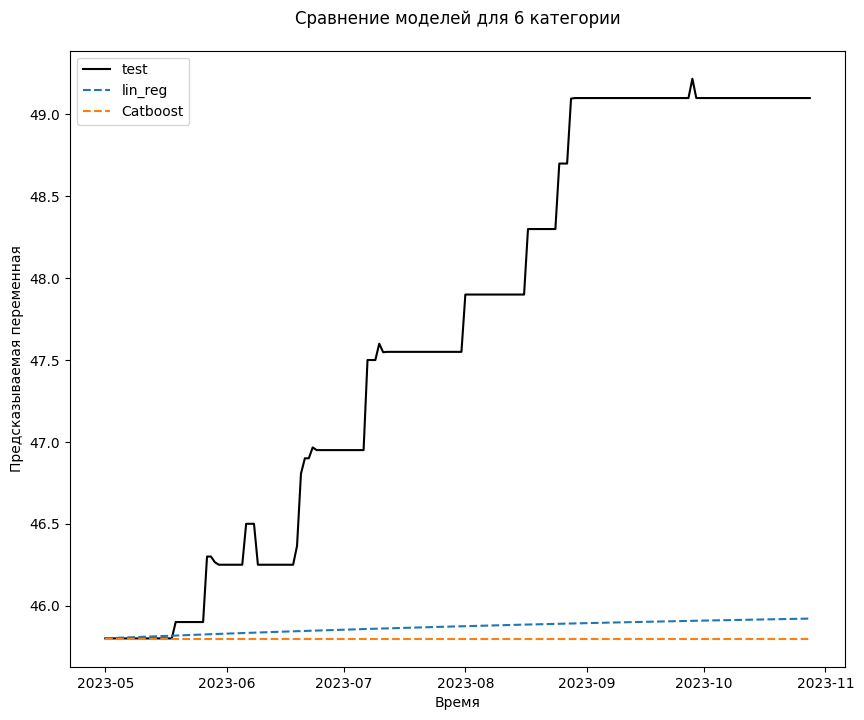

In [ ]:
# построим график сравнения прогнозов моделей
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.plot(test_6, label='test', c='black')
ax.plot(lr_predictions_6, label='lin_reg', ls='--')
ax.plot(cb_predictions_6, label='Catboost', ls='--')

ax.set_xlabel('Время')
ax.set_ylabel('Предсказываемая переменная')
ax.set_title('Сравнение моделей для 6 категории', y=1.03)
plt.legend()
plt.show()

В данной категории catboost показал чуть лучшие метрики. Однако по качеству прогноза нельзя однозначно говорить у лучшем качестве этой модели.

# 7 категория продукта

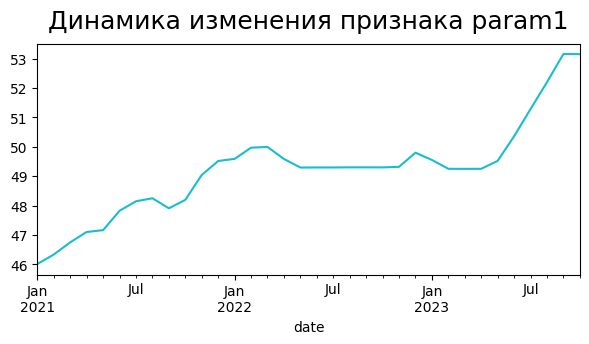

In [ ]:
# посмотрим динамику изменения признака param1 по месяцам представленных лет для param2 = 7
vis(df_7)

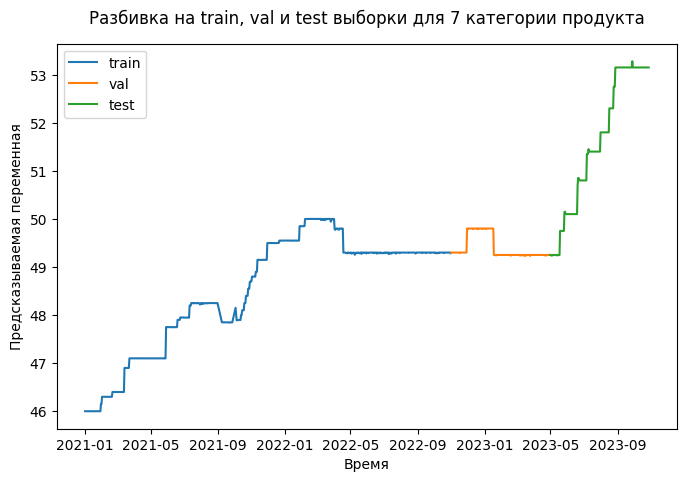

In [ ]:
# построим графики разбивки train, val и test выборки
# для 7 категории

# отрисуем данные для диапазона значений по всем категориям продуктов
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.plot(train.param1.loc[train["param2"] == 7], label='train')
ax.plot(val.param1.loc[val["param2"] == 7], label='val')
ax.plot(test.param1.loc[test["param2"] == 7], label='test')
ax.set_xlabel('Время')
ax.set_ylabel('Предсказываемая переменная')
plt.title(label='Разбивка на train, val и test выборки для 7 категории продукта', y=1.03)
plt.legend()
plt.show()

In [ ]:
# разделим наши данные на train, val и test выборки
train_7 = train.param1.loc[train["param2"] == 7]
val_7 = val.param1.loc[val["param2"] == 7]
test_7 = test.param1.loc[test["param2"] == 7]

print('Обучающая выборка для 7 категории имеет размер:     ', len(train_7))
print('Валидационная выборка для 7 категории имеет размер: ', len(val_7))
print('Тестовая выборка для 7 категории имеет размер:      ', len(test_7))

Обучающая выборка для 7 категории имеет размер:      668
Валидационная выборка для 7 категории имеет размер:  181
Тестовая выборка для 7 категории имеет размер:       181


In [ ]:
# определяем простейшую модель
linear_forecaster = ForecasterAutoreg(
    regressor=LinearRegression(),
    lags=len(val_7)
)

# обучаем модель
linear_forecaster.fit(train_7)

# строим прогноз
predictions_7 = linear_forecaster.predict(len(val_7))
predictions_7.index = val_7.index

# печатаем метрики
print(f"MAPE = {mean_absolute_percentage_error(val_7, predictions_7)}")
print(f"MAE = {mean_absolute_error(val_7, predictions_7)}")
print(f"MSE = {mean_squared_error(val_7, predictions_7)}")
print(f"R^2 = {r2_score(val_7, predictions_7)}")

MAPE = 0.005310621992010195
MAE = 0.26272185732487746
MSE = 0.08423725243955703
R^2 = -0.46069369619617695


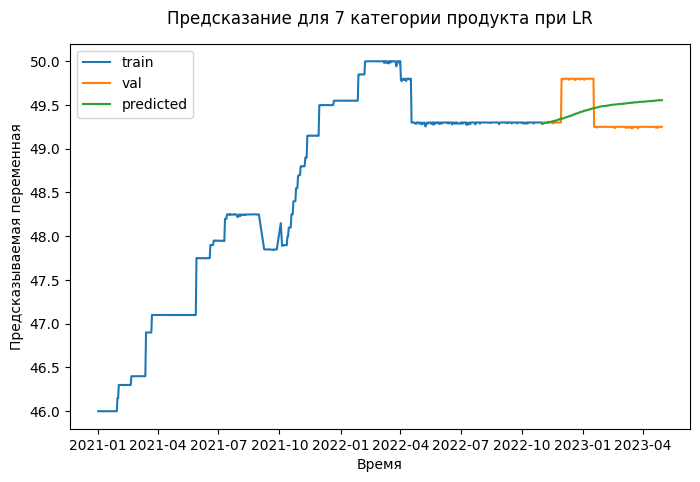

In [ ]:
# строим графики
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.plot(train_7, label='train')
ax.plot(val_7, label='val')
ax.plot(predictions_7, label='predicted')
ax.set_xlabel('Время')
ax.set_ylabel('Предсказываемая переменная')
plt.title(label='Предсказание для 7 категории продукта при LR', y=1.03)
plt.legend()
plt.show()

In [ ]:
# посмотрим прогноз с моделью CatBoostRegressor
catboost_forecaster = ForecasterAutoreg(
    regressor=CatBoostRegressor(random_seed=123, verbose=False),
    lags=5
)
catboost_forecaster.fit(train_7)
predictions_7 = catboost_forecaster.predict(len(val_7))
predictions_7.index = val_7.index

print(f"MAPE = {mean_absolute_percentage_error(val_7, predictions_7)}")
print(f"MAE = {mean_absolute_error(val_7, predictions_7)}")
print(f"MSE = {mean_squared_error(val_7, predictions_7)}")
print(f"R^2 = {r2_score(val_7, predictions_7)}")

MAPE = 0.003277796498634757
MAE = 0.16293802582430267
MSE = 0.07025803184864936
R^2 = -0.2182907354689596


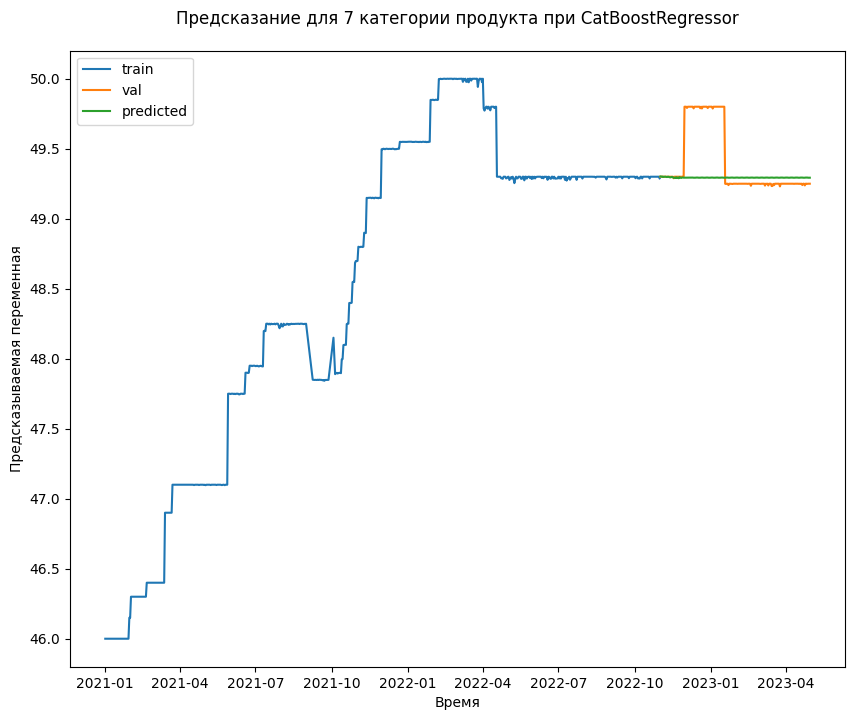

In [ ]:
# строим графики
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.plot(train_7, label='train')
ax.plot(val_7, label='val')
ax.plot(predictions_7, label='predicted')
ax.set_xlabel('Время')
ax.set_ylabel('Предсказываемая переменная')
plt.title(label='Предсказание для 7 категории продукта при CatBoostRegressor', y=1.03)
plt.legend()
plt.show()

In [ ]:
# преобразуем параметр y для подбора параметров
y = df_7.loc[:test_start, 'param1']
y.reset_index(drop= True , inplace= True )

# проверим тип и индексы для y
print(type(y))
print(y)

<class 'pandas.core.series.Series'>
0      46.000000
1      46.000000
2      46.000000
3      46.000000
4      46.000000
         ...    
845    49.249115
846    49.250000
847    49.250000
848    49.250000
849    49.250000
Name: param1, Length: 850, dtype: float64


In [ ]:
# подберем параметры

catboost_forecaster = ForecasterAutoreg(
    regressor=CatBoostRegressor(random_seed=123, verbose=False),
    lags=1 # Этот параметр будет меняться, поэтому можно поставить его каким угодно
)

lags_grid = [6, 12, [1, 2, 3, 6, 12]] # задаем сетку лагов

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15]
}
# Все параметры можно найти в документации, пройдемся по главным:
# forecaster - модель
# y - данные на которых мы хотим учиться
# param_grid, lags_grid - параметры, которые мы хотим тюнить
# steps - горизонт предсказания, на котором мы хотим валидироваться,  нашем случае - len(train_2)
# initial_train_size - тренировочные данные,  нашем случае - len(train_2)

# Возвращаемое значение - DataFrame с параметрами и результатом тестирования
results_grid = grid_search_forecaster(
                   forecaster         = catboost_forecaster,
                   y                  = y,
                   param_grid         = param_grid,
                   lags_grid          = lags_grid,
                   steps              = len(val_7),
                   refit              = False,
                   metric             = 'mean_absolute_percentage_error',
                   initial_train_size = len(df_7.loc[:val_start]),
                   fixed_train_size   = False,
                   return_best        = True,
                   n_jobs             = 'auto',
                   verbose            = False,
                   show_progress      = False
               )
results_grid = results_grid.reset_index()

Number of models compared: 27.
`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6] 
  Parameters: {'max_depth': 5, 'n_estimators': 200}
  Backtesting metric: 0.003282129044350222



In [ ]:
# создадим pipeline для обработки
pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('model', CatBoostRegressor(random_seed=123, verbose=False))
])

catboost_forecaster = ForecasterAutoreg(
    regressor=pipe,
    lags=1 # Этот параметр будет меняться, поэтому можно поставить его каким угодно
)

param_grid = {
    'model__n_estimators': [30 ,50, 100, 200],
    'model__max_depth': [3, 4, 5, 10]
}
# Теперь перетренируем линейную регрессию и catboost на всех обучающих данных и протестируем модели

linear_forecaster = ForecasterAutoreg(
    regressor=LinearRegression(),
    lags=12
)
linear_forecaster.fit(pd.concat([train_7, val_7]))
lr_predictions_7 = linear_forecaster.predict(len(test_7))
lr_predictions_7.index = test_7.index

print(f"MAPE = {mean_absolute_percentage_error(test_7, lr_predictions_7)}")
print(f"MAE = {mean_absolute_error(test_7, lr_predictions_7)}")
print(f"MSE = {mean_squared_error(test_7, lr_predictions_7)}")
print(f"R^2 = {r2_score(test_7, lr_predictions_7)}")

MAPE = 0.04294280187424853
MAE = 2.250002978463829
MSE = 6.873872360675019
R^2 = -2.549956179198834


In [ ]:
pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('model', CatBoostRegressor(**{'max_depth': 5, 'n_estimators': 50}, random_seed=123, verbose=False))
])
catboost_forecaster = ForecasterAutoreg(
    regressor=pipe,
    lags=[1, 2, 3, 6, 12]
)

catboost_forecaster.fit(pd.concat([train_7, val_7]))
cb_predictions_7  = catboost_forecaster.predict(len(test_7))
cb_predictions_7.index = test_7.index

print(f"MAPE = {mean_absolute_percentage_error(test_7, cb_predictions_5)}")
print(f"MAE = {mean_absolute_error(test_7, cb_predictions_7)}")
print(f"MSE = {mean_squared_error(test_7, cb_predictions_7)}")
print(f"R^2 = {r2_score(test_7, cb_predictions_7)}")

MAPE = 0.09783797788312218
MAE = 2.329909100110329
MSE = 7.359171540423073
R^2 = -2.800585043325364


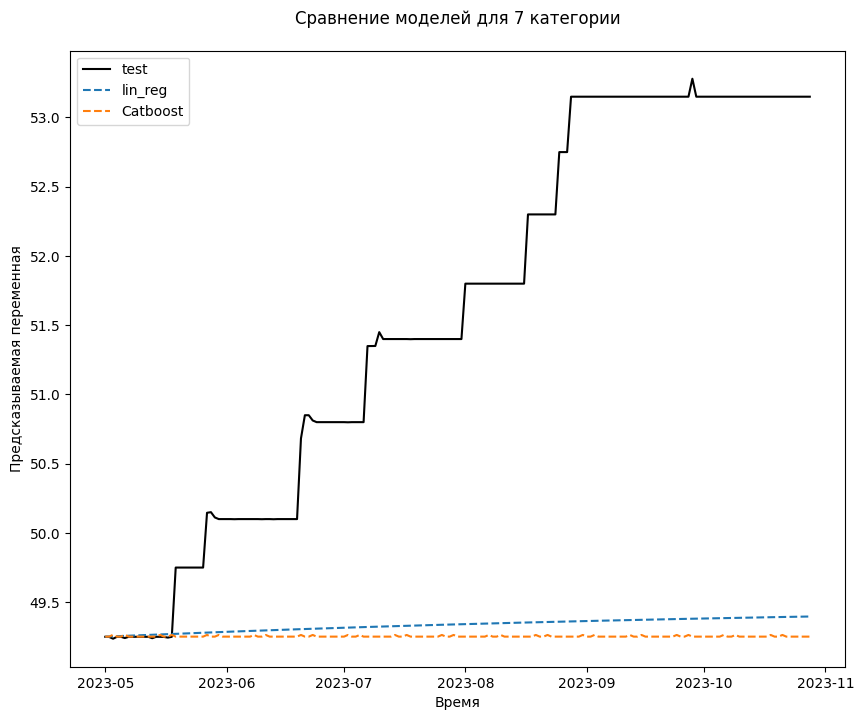

In [ ]:
# построим график сравнения прогнозов моделей
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.plot(test_7, label='test', c='black')
ax.plot(lr_predictions_7, label='lin_reg', ls='--')
ax.plot(cb_predictions_7, label='Catboost', ls='--')

ax.set_xlabel('Время')
ax.set_ylabel('Предсказываемая переменная')
ax.set_title('Сравнение моделей для 7 категории', y=1.03)
plt.legend()
plt.show()

Для данной категории товаров также не наблюдается сильное различие в метриках и качество модели линейной регрессии и catboost: плюс минус на одном уровне.

# 8 категория продукта

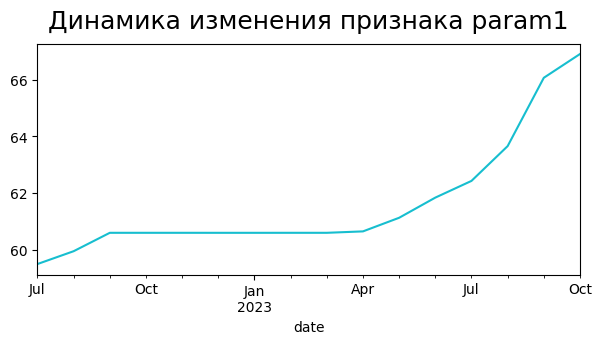

In [ ]:
# посмотрим динамику изменения признака param1 по месяцам представленных лет для param2 = 8
vis(df_8)

Обучающая выборка для 3 категории имеет размер:      148
Валидационная выборка для 3 категории имеет размер:  121
Тестовая выборка для 3 категории имеет размер:       211



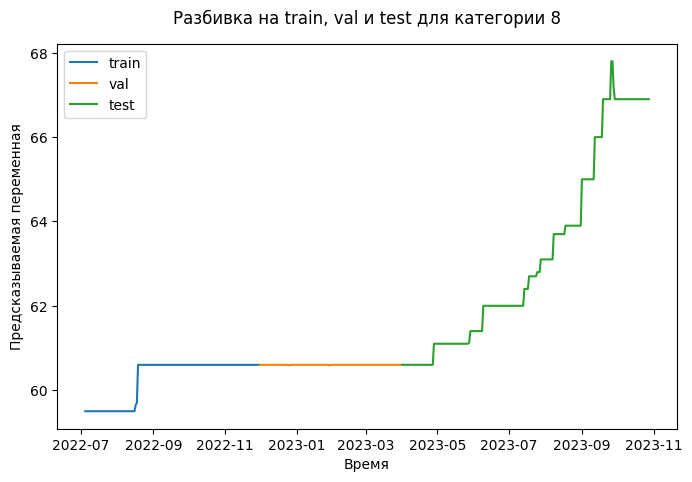

In [ ]:
# определим границы наших выборок по дате
val_start_8 = pd.to_datetime('2022-12-01')
test_start_8 = pd.to_datetime('2023-04-01')

# разделим наши данные на train, val и test выборки
train_8 = df_8[df_8.index < val_start_8]
train_8 = train_8.loc[:,'param1']

val_8 = df_8[(df_8.index >= val_start_8) & (df_8.index < test_start_8)]
val_8 = val_8.loc[:,'param1']

test_8 = df_8[(df_8.index >= test_start_8)]
test_8 = test_8.loc[:,'param1']


print('Обучающая выборка для 3 категории имеет размер:     ', len(train_8))
print('Валидационная выборка для 3 категории имеет размер: ', len(val_8))
print('Тестовая выборка для 3 категории имеет размер:      ', len(test_8))
print('')

# отрисуем данные для диапазона значений по всем категориям продуктов
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.plot(train_8, label='train')
ax.plot(val_8, label='val')
ax.plot(test_8, label='test')
ax.set_xlabel('Время')
ax.set_ylabel('Предсказываемая переменная')
plt.title(label='Разбивка на train, val и test для категории 8', y=1.03)
plt.legend()
plt.show()

In [ ]:
# определяем простейшую модель
linear_forecaster = ForecasterAutoreg(
    regressor=LinearRegression(),
    lags=len(val_8)
)

# обучаем модель
linear_forecaster.fit(train_8)

# строим прогноз
predictions_8 = linear_forecaster.predict(len(val_8))
predictions_8.index = val_8.index

# печатаем метрики
print(f"MAPE = {mean_absolute_percentage_error(val_8, predictions_8)}")
print(f"MAE = {mean_absolute_error(val_8, predictions_8)}")
print(f"MSE = {mean_squared_error(val_8, predictions_8)}")
print(f"R^2 = {r2_score(val_8, predictions_8)}")

MAPE = 1.734066739591919e-05
MAE = 0.0010507820752553674
MSE = 4.255871409398868e-06
R^2 = -0.08654820353949688


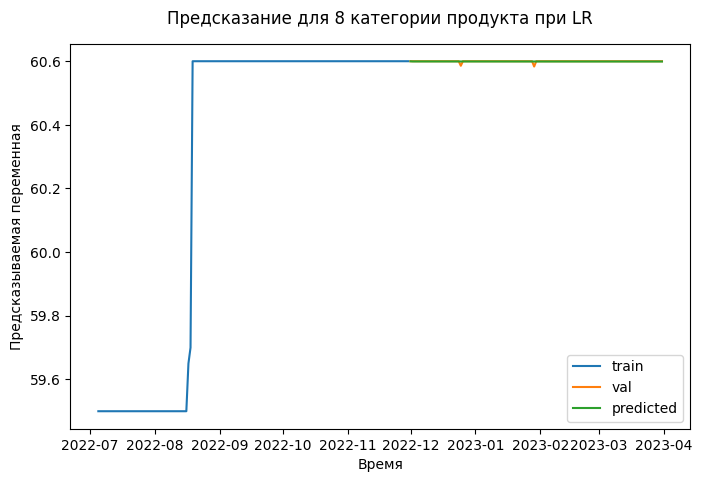

In [ ]:
# строим графики
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.plot(train_8, label='train')
ax.plot(val_8, label='val')
ax.plot(predictions_8, label='predicted')
ax.set_xlabel('Время')
ax.set_ylabel('Предсказываемая переменная')
plt.title(label='Предсказание для 8 категории продукта при LR', y=1.03)
plt.legend()
plt.show()

In [ ]:
# посмотрим прогноз с моделью CatBoostRegressor
catboost_forecaster = ForecasterAutoreg(
    regressor=CatBoostRegressor(random_seed=123, verbose=False),
    lags=5
)
catboost_forecaster.fit(train_8)
predictions_8 = catboost_forecaster.predict(len(val_8))
predictions_8.index = val_8.index

print(f"MAPE = {mean_absolute_percentage_error(val_8, predictions_8)}")
print(f"MAE = {mean_absolute_error(val_8, predictions_8)}")
print(f"MSE = {mean_squared_error(val_8, predictions_8)}")
print(f"R^2 = {r2_score(val_8, predictions_8)}")

MAPE = 4.2466330575731915e-06
MAE = 0.0002572802380745011
MSE = 3.981530851021111e-06
R^2 = -0.016507496904171637


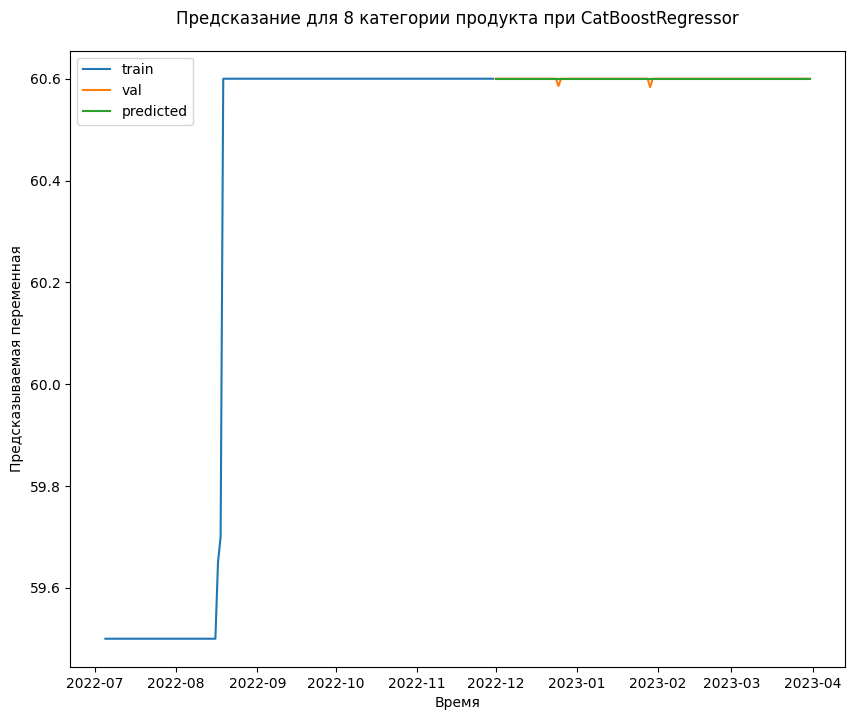

In [ ]:
# строим графики
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.plot(train_8, label='train')
ax.plot(val_8, label='val')
ax.plot(predictions_8, label='predicted')
ax.set_xlabel('Время')
ax.set_ylabel('Предсказываемая переменная')
plt.title(label='Предсказание для 8 категории продукта при CatBoostRegressor', y=1.03)
plt.legend()
plt.show()

In [ ]:
# преобразуем параметр y для подбора параметров
y = df_8.loc[:test_start, 'param1']
y.reset_index(drop= True , inplace= True )

# проверим тип и индексы для y
print(type(y))
print(y)

<class 'pandas.core.series.Series'>
0      59.5
1      59.5
2      59.5
3      59.5
4      59.5
       ... 
295    60.6
296    61.1
297    61.1
298    61.1
299    61.1
Name: param1, Length: 300, dtype: float64


In [ ]:
# подберем параметры

catboost_forecaster = ForecasterAutoreg(
    regressor=CatBoostRegressor(random_seed=123, verbose=False),
    lags=1 # Этот параметр будет меняться, поэтому можно поставить его каким угодно
)

lags_grid = [6, 12, [1, 2, 3, 6, 12]] # задаем сетку лагов

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15]
}
# Все параметры можно найти в документации, пройдемся по главным:
# forecaster - модель
# y - данные на которых мы хотим учиться
# param_grid, lags_grid - параметры, которые мы хотим тюнить
# steps - горизонт предсказания, на котором мы хотим валидироваться,  нашем случае - len(train_2)
# initial_train_size - тренировочные данные,  нашем случае - len(train_2)

# Возвращаемое значение - DataFrame с параметрами и результатом тестирования
results_grid = grid_search_forecaster(
                   forecaster         = catboost_forecaster,
                   y                  = y,
                   param_grid         = param_grid,
                   lags_grid          = lags_grid,
                   steps              = len(val_8),
                   refit              = False,
                   metric             = 'mean_absolute_percentage_error',
                   initial_train_size = len(df_8.loc[:val_start]),
                   fixed_train_size   = False,
                   return_best        = True,
                   n_jobs             = 'auto',
                   verbose            = False,
                   show_progress      = False
               )
results_grid = results_grid.reset_index()

Number of models compared: 27.
`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
  Parameters: {'max_depth': 10, 'n_estimators': 50}
  Backtesting metric: 0.00018368129256229827



In [ ]:
# создадим pipeline для обработки
pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('model', CatBoostRegressor(random_seed=123, verbose=False))
])

catboost_forecaster = ForecasterAutoreg(
    regressor=pipe,
    lags=1 # Этот параметр будет меняться, поэтому можно поставить его каким угодно
)

param_grid = {
    'model__n_estimators': [30 ,50],
    'model__max_depth': [3, 4, 5, 10]
}
# Теперь перетренируем линейную регрессию и catboost на всех обучающих данных и протестируем модели

linear_forecaster = ForecasterAutoreg(
    regressor=LinearRegression(),
    lags=12
)
linear_forecaster.fit(pd.concat([train_8, val_8]))
lr_predictions_8 = linear_forecaster.predict(len(test_8))
lr_predictions_8.index = test_8.index

print(f"MAPE = {mean_absolute_percentage_error(test_8, lr_predictions_8)}")
print(f"MAE = {mean_absolute_error(test_8, lr_predictions_8)}")
print(f"MSE = {mean_squared_error(test_8, lr_predictions_8)}")
print(f"R^2 = {r2_score(test_8, lr_predictions_8)}")

MAPE = 0.039813045167228826
MAE = 2.591623069899613
MSE = 11.809645825001251
R^2 = -1.3187828201488156


In [ ]:
pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('model', CatBoostRegressor(**{'max_depth': 5, 'n_estimators': 50}, random_seed=123, verbose=False))
])
catboost_forecaster = ForecasterAutoreg(
    regressor=pipe,
    lags=[1, 2, 3, 6, 12]
)

catboost_forecaster.fit(pd.concat([train_8, val_8]))
cb_predictions_8  = catboost_forecaster.predict(len(test_8))
cb_predictions_8.index = test_8.index

print(f"MAPE = {mean_absolute_percentage_error(test_8, cb_predictions_8)}")
print(f"MAE = {mean_absolute_error(test_8, cb_predictions_8)}")
print(f"MSE = {mean_squared_error(test_8, cb_predictions_8)}")
print(f"R^2 = {r2_score(test_8, cb_predictions_8)}")

MAPE = 0.039812670524218864
MAE = 2.591598639449862
MSE = 11.80942013151594
R^2 = -1.318738506019153


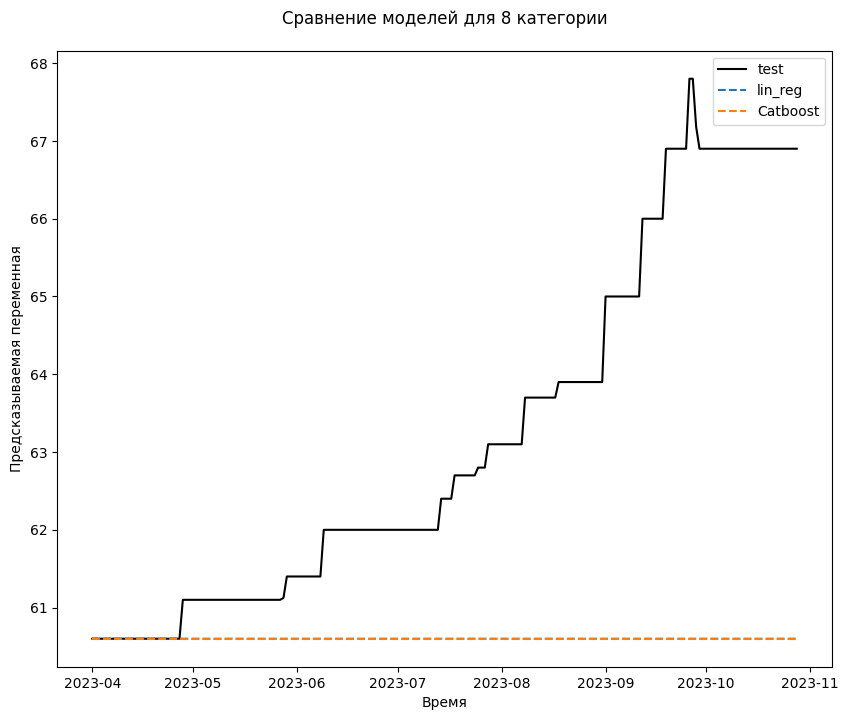

In [ ]:
# построим график сравнения прогнозов моделей
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.plot(test_8, label='test', c='black')
ax.plot(lr_predictions_8, label='lin_reg', ls='--')
ax.plot(cb_predictions_8, label='Catboost', ls='--')

ax.set_xlabel('Время')
ax.set_ylabel('Предсказываемая переменная')
ax.set_title('Сравнение моделей для 8 категории', y=1.03)
plt.legend()
plt.show()

Для товара в категории 8 прогноз выглядит идентичным для рассматриваемых моделей, таким образом нельзя реккомендовать какую-то одну к выбору.

# Вывод по работе

Был проведен EDA данных, применены модели ARIMA и SARIMAX. Построен прогноз для данных на 36 месяцев от последней даты test выборки.

Разобраны категории продуктов, построены регрессионные модули по linear regression, catboost regression, комбинации моделей в pipeline.

Для различных категорий продуктов при текущих условиях, предпочтительные модели различаются.

Так как данные по ценам продуктов на АЗС сильно зависят от геополитической ситуации, видна сложность предсказания цен. На графиках прогнозную стоимость можно принять как базовую прогнозную модель в постоянно изменяюющейся геополитической ситуации и санкций.

Также, на будущее желательно провести спектральный анализ – т.к. возможно методы анализа временных рядов могли быть недостаточными, если бы данные обладали сезонностью. Этот фактор не был учтен в анализе.